In [379]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier

import re

from sodapy import Socrata

### Read Data

In [380]:

import pandas as pd
from sodapy import Socrata

client = Socrata("data.texas.gov", None)

results = client.get("ubdr-4uff", limit=300000)

# Convert to pandas DataFrame
df1 = pd.DataFrame.from_records(results)

In [518]:
df = df1

In [519]:
df['reason'].value_counts()

reason
Denial Of Claim                                                                                                                                      26193
Delays (Claims Handling)                                                                                                                             25881
Unsatisfactory Settle/Offer                                                                                                                          20601
Cust Service Claim Handling; Delays (Claims Handling)                                                                                                17912
Balance Billing; Unsatisfactory Settle/Offer                                                                                                         17567
                                                                                                                                                     ...  
Agent Handling; Delays (Policyholder Service); Disclosure Of Be

In [520]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259694 entries, 0 to 259693
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   complaint_number          259694 non-null  object        
 1   respondent_name           259694 non-null  object        
 2   complainant_role          259694 non-null  object        
 3   reason                    259688 non-null  object        
 4   complaint_confirmed_code  259689 non-null  object        
 5   disposition               258656 non-null  object        
 6   received_date             259694 non-null  datetime64[ns]
 7   closed_date               259694 non-null  datetime64[ns]
 8   complaint_type            259693 non-null  object        
 9   coverage_type             259694 non-null  object        
 10  coverage_level            259694 non-null  object        
 11  respondent_id             259694 non-null  object        
 12  re

In [521]:
df.head()

complaint_number                                    respondent_name  \
0                1                METROPOLITAN LIFE INSURANCE COMPANY   
1                2                       AETNA LIFE INSURANCE COMPANY   
2                3  BLUE CROSS AND BLUE SHIELD OF TEXAS, A DIVISIO...   
3                4  BLUE CROSS AND BLUE SHIELD OF TEXAS, A DIVISIO...   
4                5            CHARTER OAK FIRE INSURANCE COMPANY, THE   

  complainant_role                       reason complaint_confirmed_code  \
0         Relative  Cust Service Claim Handling                       No   
1         Provider     Delays (Claims Handling)                       No   
2         Provider              Denial Of Claim                       No   
3         Provider              Denial Of Claim                       No   
4          Insured  Unsatisfactory Settle/Offer                       No   

                                       disposition received_date closed_date  \
0                                            Other    2012-06-12  2012-07-25   
1                            Information Furnished    2012-06-21  2012-08-01   
2                                            Other    2012-06-11  2012-07-30   
3                                            Other    2012-06-28  2012-07-30   
4  Contract Language/Legal Issue; Question of Fact    2012-06-13  2012-07-17   

              complaint_type        coverage_type  ... complainant_type  \
0  Life, Accident and Health       Life & Annuity  ...             INDV   
1  Life, Accident and Health  Accident and Health  ...              ORG   
2  Life, Accident and Health  Accident and Health  ...              ORG   
3  Life, Accident and Health  Accident and Health  ...              ORG   
4      Property and Casualty           Automobile  ...             INDV   

  involved_party_type                                            keyword  \
0                 NaN                                                NaN   
1             Insured                                                NaN   
2                 NaN                                                NaN   
3                 NaN                                                NaN   
4                 NaN  2012 NORTH TEXAS TORNADOES; ADJUSTER'S HANDLIN...   

  Open_Year Open_Month Open_Day Close_Year  Close_Month  Close_Day  Duration  
0      2012          6       12       2012            7         25        43  
1      2012          6       21       2012            8          1        41  
2      2012          6       11       2012            7         30        49  
3      2012          6       28       2012            7         30        32  
4      2012          6       13       2012            7         17        34  

[5 rows x 24 columns]

In [522]:
df.columns

Index(['complaint_number', 'respondent_name', 'complainant_role', 'reason',
       'complaint_confirmed_code', 'disposition', 'received_date',
       'closed_date', 'complaint_type', 'coverage_type', 'coverage_level',
       'respondent_id', 'respondent_role', 'respondent_type',
       'complainant_type', 'involved_party_type', 'keyword', 'Open_Year',
       'Open_Month', 'Open_Day', 'Close_Year', 'Close_Month', 'Close_Day',
       'Duration'],
      dtype='object')

## Data Preprocessing

1) Convert to Datetime

In [523]:
df['closed_date'] = pd.to_datetime(df['closed_date'])
df['received_date'] = pd.to_datetime(df['received_date'])

2) Create 'Year', 'Month' and 'Day' columns

In [524]:
df['Open_Year']=df['received_date'].dt.year
df['Open_Month']=df['received_date'].dt.month
df['Open_Day']=df['received_date'].dt.day
df['Close_Year']=df['closed_date'].dt.year
df['Close_Month']=df['closed_date'].dt.month
df['Close_Day']=df['closed_date'].dt.day

3) Create 'Duration' column

In [525]:
df['Duration'] = (df['closed_date'] - df['received_date']).dt.days

4) Calcurate the duration of open complaints(NaN)

In [526]:
df['Duration']=df['Duration'].fillna(dt.datetime.now()-df['received_date'])

5) Create new column status which includes binary numbers.
Verdict won 'Yes' = 1 and Verdict won 'No' = 0

In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259694 entries, 0 to 259693
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   complaint_number          259694 non-null  object        
 1   respondent_name           259694 non-null  object        
 2   complainant_role          259694 non-null  object        
 3   reason                    259688 non-null  object        
 4   complaint_confirmed_code  259689 non-null  object        
 5   disposition               258656 non-null  object        
 6   received_date             259694 non-null  datetime64[ns]
 7   closed_date               259694 non-null  datetime64[ns]
 8   complaint_type            259693 non-null  object        
 9   coverage_type             259694 non-null  object        
 10  coverage_level            259694 non-null  object        
 11  respondent_id             259694 non-null  object        
 12  re

In [528]:
df.head()

complaint_number                                    respondent_name  \
0                1                METROPOLITAN LIFE INSURANCE COMPANY   
1                2                       AETNA LIFE INSURANCE COMPANY   
2                3  BLUE CROSS AND BLUE SHIELD OF TEXAS, A DIVISIO...   
3                4  BLUE CROSS AND BLUE SHIELD OF TEXAS, A DIVISIO...   
4                5            CHARTER OAK FIRE INSURANCE COMPANY, THE   

  complainant_role                       reason complaint_confirmed_code  \
0         Relative  Cust Service Claim Handling                       No   
1         Provider     Delays (Claims Handling)                       No   
2         Provider              Denial Of Claim                       No   
3         Provider              Denial Of Claim                       No   
4          Insured  Unsatisfactory Settle/Offer                       No   

                                       disposition received_date closed_date  \
0                                            Other    2012-06-12  2012-07-25   
1                            Information Furnished    2012-06-21  2012-08-01   
2                                            Other    2012-06-11  2012-07-30   
3                                            Other    2012-06-28  2012-07-30   
4  Contract Language/Legal Issue; Question of Fact    2012-06-13  2012-07-17   

              complaint_type        coverage_type  ... complainant_type  \
0  Life, Accident and Health       Life & Annuity  ...             INDV   
1  Life, Accident and Health  Accident and Health  ...              ORG   
2  Life, Accident and Health  Accident and Health  ...              ORG   
3  Life, Accident and Health  Accident and Health  ...              ORG   
4      Property and Casualty           Automobile  ...             INDV   

  involved_party_type                                            keyword  \
0                 NaN                                                NaN   
1             Insured                                                NaN   
2                 NaN                                                NaN   
3                 NaN                                                NaN   
4                 NaN  2012 NORTH TEXAS TORNADOES; ADJUSTER'S HANDLIN...   

  Open_Year Open_Month Open_Day Close_Year  Close_Month  Close_Day  Duration  
0      2012          6       12       2012            7         25        43  
1      2012          6       21       2012            8          1        41  
2      2012          6       11       2012            7         30        49  
3      2012          6       28       2012            7         30        32  
4      2012          6       13       2012            7         17        34  

[5 rows x 24 columns]

In [529]:
# Trim whitespace from all columns with string data
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [530]:
# Convert all columns to propercase if they are strings
df = df.apply(lambda x: x.str.title() if x.dtype == "object" else x)

In [531]:

# Remove the text ", The" from respondent_name column if ends in ", The"
df['respondent_name'] = df['respondent_name'].str.rstrip(', The')

In [395]:

# # Split the 'reason' column by semicolons and expand it into multiple rows
# expanded_df = df['reason'].str.split(';', expand=True)

# # Iterate through each expanded column to create a new DataFrame
# result = pd.DataFrame()

# for col in expanded_df.columns:
#     temp_df = df.copy()
#     temp_df['reason'] = expanded_df[col]
#     result = pd.concat([result, temp_df])

# # Drop rows where 'reason' is NaN (result of splitting empty parts)
# result = result.dropna(subset=['reason'])

# # Reset index for clarity
# result = result.reset_index(drop=True)

# # Print the resulting DataFrame

# df = result

In [532]:


# Define keywords for categorizing dispositions as 'verdict won' or 'verdict not won'
verdict_won_keywords = ["Claim Settled", "Additional Monies Received"]
verdict_not_won_keywords = ["No Jurisdiction", "Company Position Upheld", "Insufficient Information", "Contract Language/Legal Issue", "Question of Fact"]

# Define the categorize_verdict function
def categorize_verdict(disposition):
    if any(keyword in disposition for keyword in verdict_won_keywords):
        return "Yes"
    elif any(keyword in disposition for keyword in verdict_not_won_keywords):
        return "No"
    else:
        return "Uncategorized"

# Convert the disposition column to strings
df['disposition'] = df['disposition'].astype(str)

# Apply categorization to the disposition data
df['verdict_passed'] = df['disposition'].apply(categorize_verdict)

# Drop rows where the disposition was categorized as "Uncategorized"
df = df[df['verdict_passed'] != "Uncategorized"]

# Replace disposition column with verdict_passed column and drop verdict_passed
# df['disposition'] = df['verdict_passed']
# df = df.drop(columns=['verdict_passed'])

# Continue with the rest of your code


In [533]:
df.head()

complaint_number                                    respondent_name  \
4                 5                 Charter Oak Fire Insurance Company   
5                 6            Reassure America Life Insurance Company   
6                 7                     Usaa General Indemnity Company   
7                 8  Blue Cross And Blue Shield Of Texas, A Divisio...   
11               12  Healthspring Life & Health Insurance Company, ...   

   complainant_role                         reason complaint_confirmed_code  \
4           Insured    Unsatisfactory Settle/Offer                       No   
5           Insured  Cash Value; Misrepresentation                       No   
6       Third Party    Unsatisfactory Settle/Offer                       No   
7           Insured                Denial Of Claim                       No   
11         Relative                Denial Of Claim                       No   

                                        disposition received_date closed_date  \
4   Contract Language/Legal Issue; Question Of Fact    2012-06-13  2012-07-17   
5                                   No Jurisdiction    2012-06-18  2012-07-30   
6                   Question Of Fact; Claim Settled    2012-02-27  2012-07-02   
7                           Company Position Upheld    2012-06-19  2012-08-06   
11                    Contract Language/Legal Issue    2012-06-18  2012-07-19   

               complaint_type        coverage_type  ...  \
4       Property And Casualty           Automobile  ...   
5   Life, Accident And Health       Life & Annuity  ...   
6       Property And Casualty           Automobile  ...   
7   Life, Accident And Health  Accident And Health  ...   
11  Life, Accident And Health  Accident And Health  ...   

             involved_party_type  \
4                            NaN   
5                            NaN   
6                        Insured   
7                            NaN   
11  Gr Elected Official; Insured   

                                              keyword Open_Year Open_Month  \
4   2012 North Texas Tornadoes; Adjuster'S Handlin...      2012          6   
5                                                 NaN      2012          6   
6                                    Claim Evaluation      2012          2   
7                                                 NaN      2012          6   
11                                                NaN      2012          6   

   Open_Day Close_Year Close_Month  Close_Day  Duration  verdict_passed  
4        13       2012           7         17        34              No  
5        18       2012           7         30        42              No  
6        27       2012           7          2       126             Yes  
7        19       2012           8          6        48              No  
11       18       2012           7         19        31              No  

[5 rows x 25 columns]

In [534]:
def close_status(a):
    if a=='Yes':
        return 1
    else:
        return 0

In [535]:
df['status'] = df['verdict_passed'].apply(close_status)

In [536]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179993 entries, 4 to 259692
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   complaint_number          179993 non-null  object        
 1   respondent_name           179993 non-null  object        
 2   complainant_role          179993 non-null  object        
 3   reason                    179992 non-null  object        
 4   complaint_confirmed_code  179988 non-null  object        
 5   disposition               179993 non-null  object        
 6   received_date             179993 non-null  datetime64[ns]
 7   closed_date               179993 non-null  datetime64[ns]
 8   complaint_type            179992 non-null  object        
 9   coverage_type             179993 non-null  object        
 10  coverage_level            179993 non-null  object        
 11  respondent_id             179993 non-null  object        
 12  respond

In [515]:
# Average Duration for each complaint settled
# 		- Top insurance companies with conflicts,- Blue cross and Blue shield of Texas
# 		- Time Series - No of Conflicts is seen decreased after 2020
# 		- Top Categories where conflict arises is Accident and health
# 		- Correlation matrix
# 		- Top reason to file - Denial and Delays
# 		- Majority of individuals file against organization

In [543]:
# fIND THE AVEARAGE DURATION FOR status = 1
df[df['status']==1]['Duration'].mean()

94.66040983165708

<Axes: xlabel='Open_Year'>

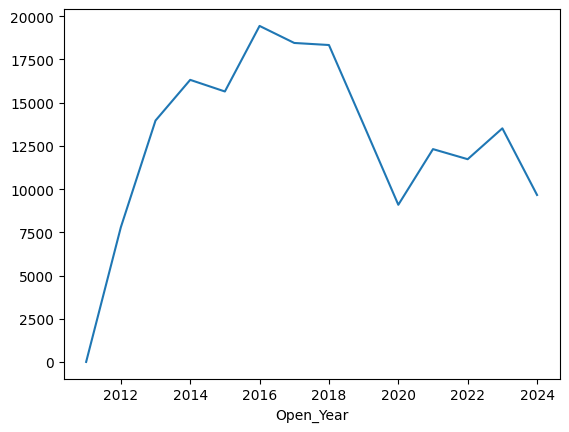

In [ ]:
# Plot the line plot for number of complaints for each year
df['Open_Year'].value_counts().sort_index().plot(kind='line')

# make a decade analysis

df['Decade'] = df['Open_Year']//10*10




## Visualizations

1) Bar chart by 'Conclusion' and count

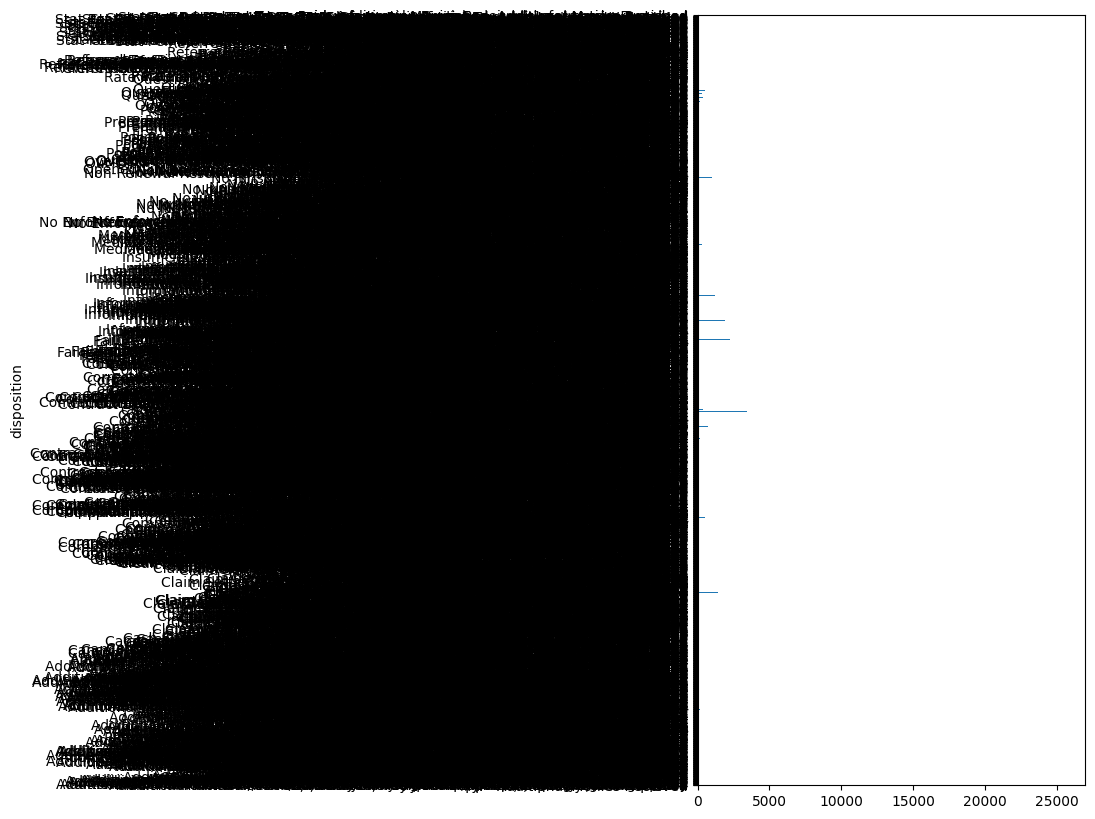

In [290]:

plt.figure(figsize=(5,10))
df.groupby('disposition')['complaint_number'].count().plot.barh();


2) Bar chart by 'Company'(Top 50) and count

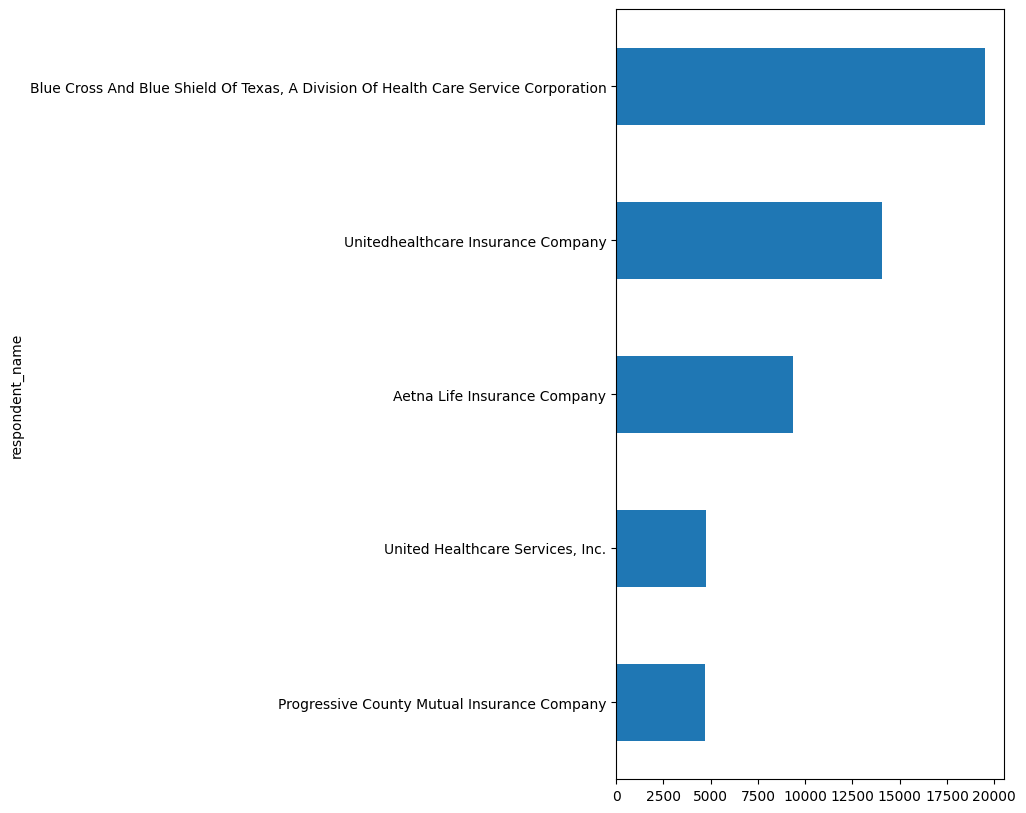

In [517]:
plt.figure(figsize=(5,10))
df.groupby('respondent_name')['complaint_number'].count().sort_values(ascending=True).tail(5).plot.barh();

In [292]:
print("There are " + str(df['respondent_name'].nunique()) + " unique companies in data")

There are 6319 unique companies in data


7) Time series by 'Opened''File No' count

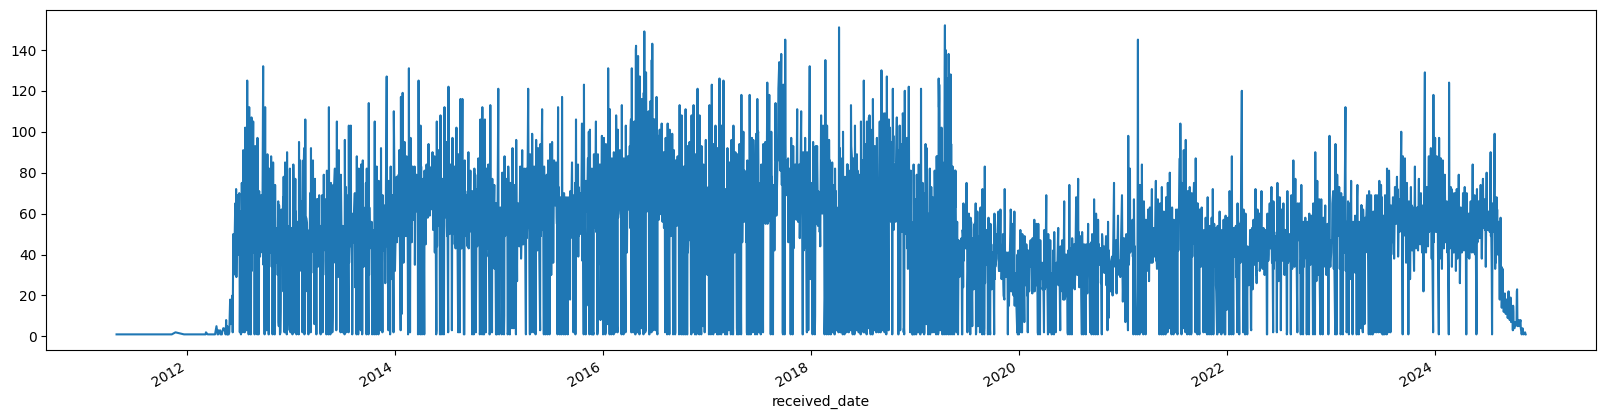

In [293]:
plt.figure(figsize=(20,5))
df.groupby('received_date')['complaint_number'].count().plot();

9) Bar plot by Top 30 'Coverage'

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179993 entries, 4 to 259692
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   complaint_number          179993 non-null  object        
 1   respondent_name           179993 non-null  object        
 2   complainant_role          179993 non-null  object        
 3   reason                    179992 non-null  object        
 4   complaint_confirmed_code  179988 non-null  object        
 5   disposition               179993 non-null  object        
 6   received_date             179993 non-null  datetime64[ns]
 7   closed_date               179993 non-null  datetime64[ns]
 8   complaint_type            179992 non-null  object        
 9   coverage_type             179993 non-null  object        
 10  coverage_level            179993 non-null  object        
 11  respondent_id             179993 non-null  object        
 12  respond

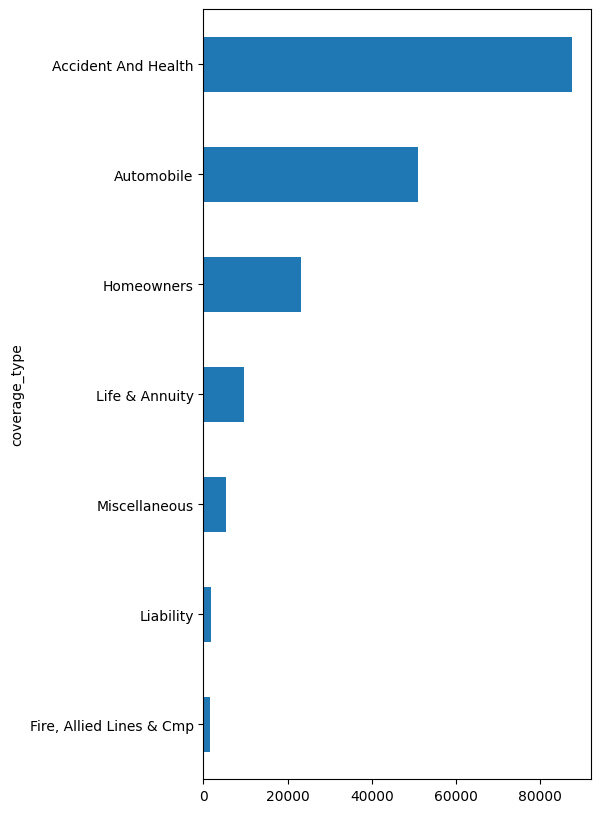

In [295]:
plt.figure(figsize=(5,10))
df.groupby('coverage_type')['complaint_number'].count().sort_values(ascending=True).tail(30).plot.barh();

In [296]:
print("There are " + str(df['coverage_type'].nunique()) + " unique coverages in data")

There are 7 unique coverages in data


10) Bar plot by 'Reason'

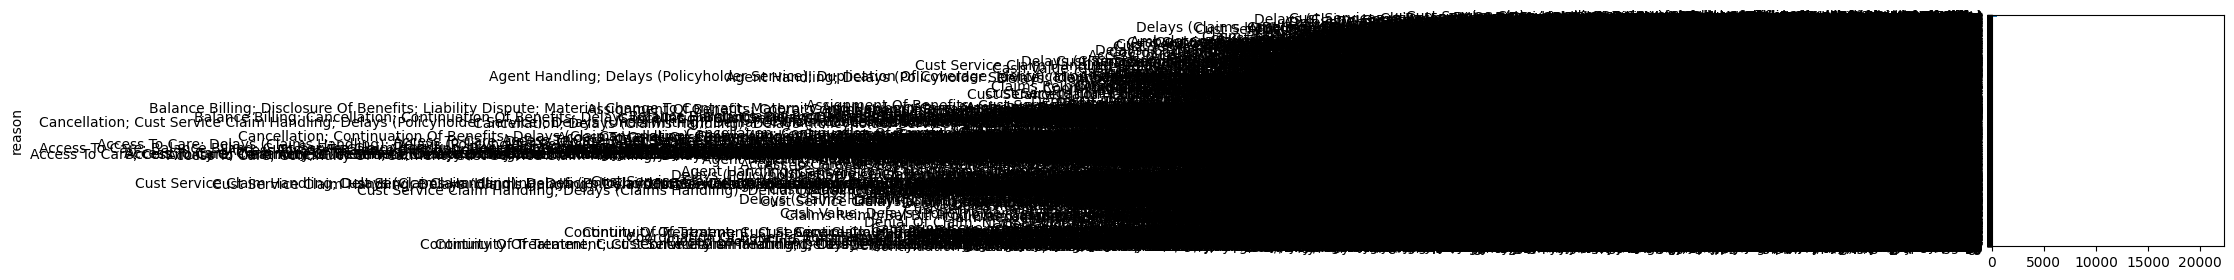

In [297]:
plt.figure(figsize=(3,3))
df.groupby('reason')['complaint_number'].count().sort_values(ascending=True).plot.barh();

11) Bar plot by 'Disposition'

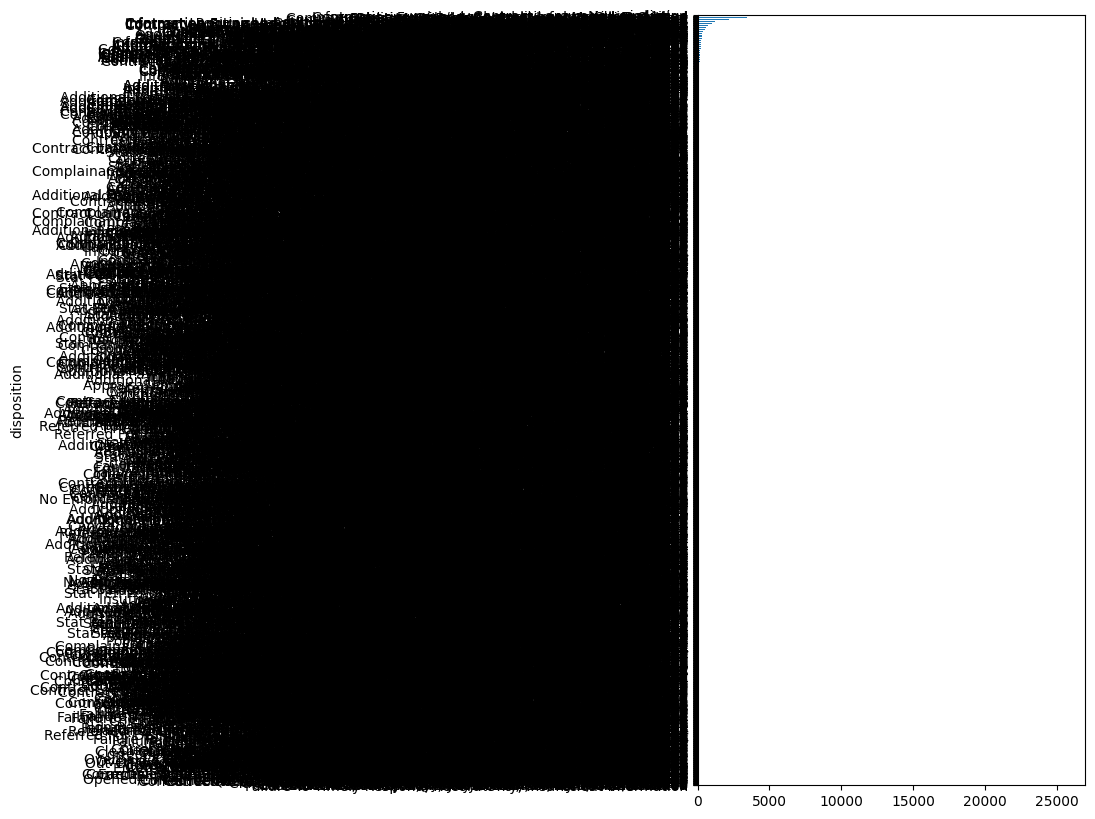

In [298]:
plt.figure(figsize=(5,10))
df.groupby('disposition')['complaint_number'].count().sort_values(ascending=True).plot.barh();

12) Bar plot by 'Conclusion'

<Axes: xlabel='count', ylabel='respondent_name'>

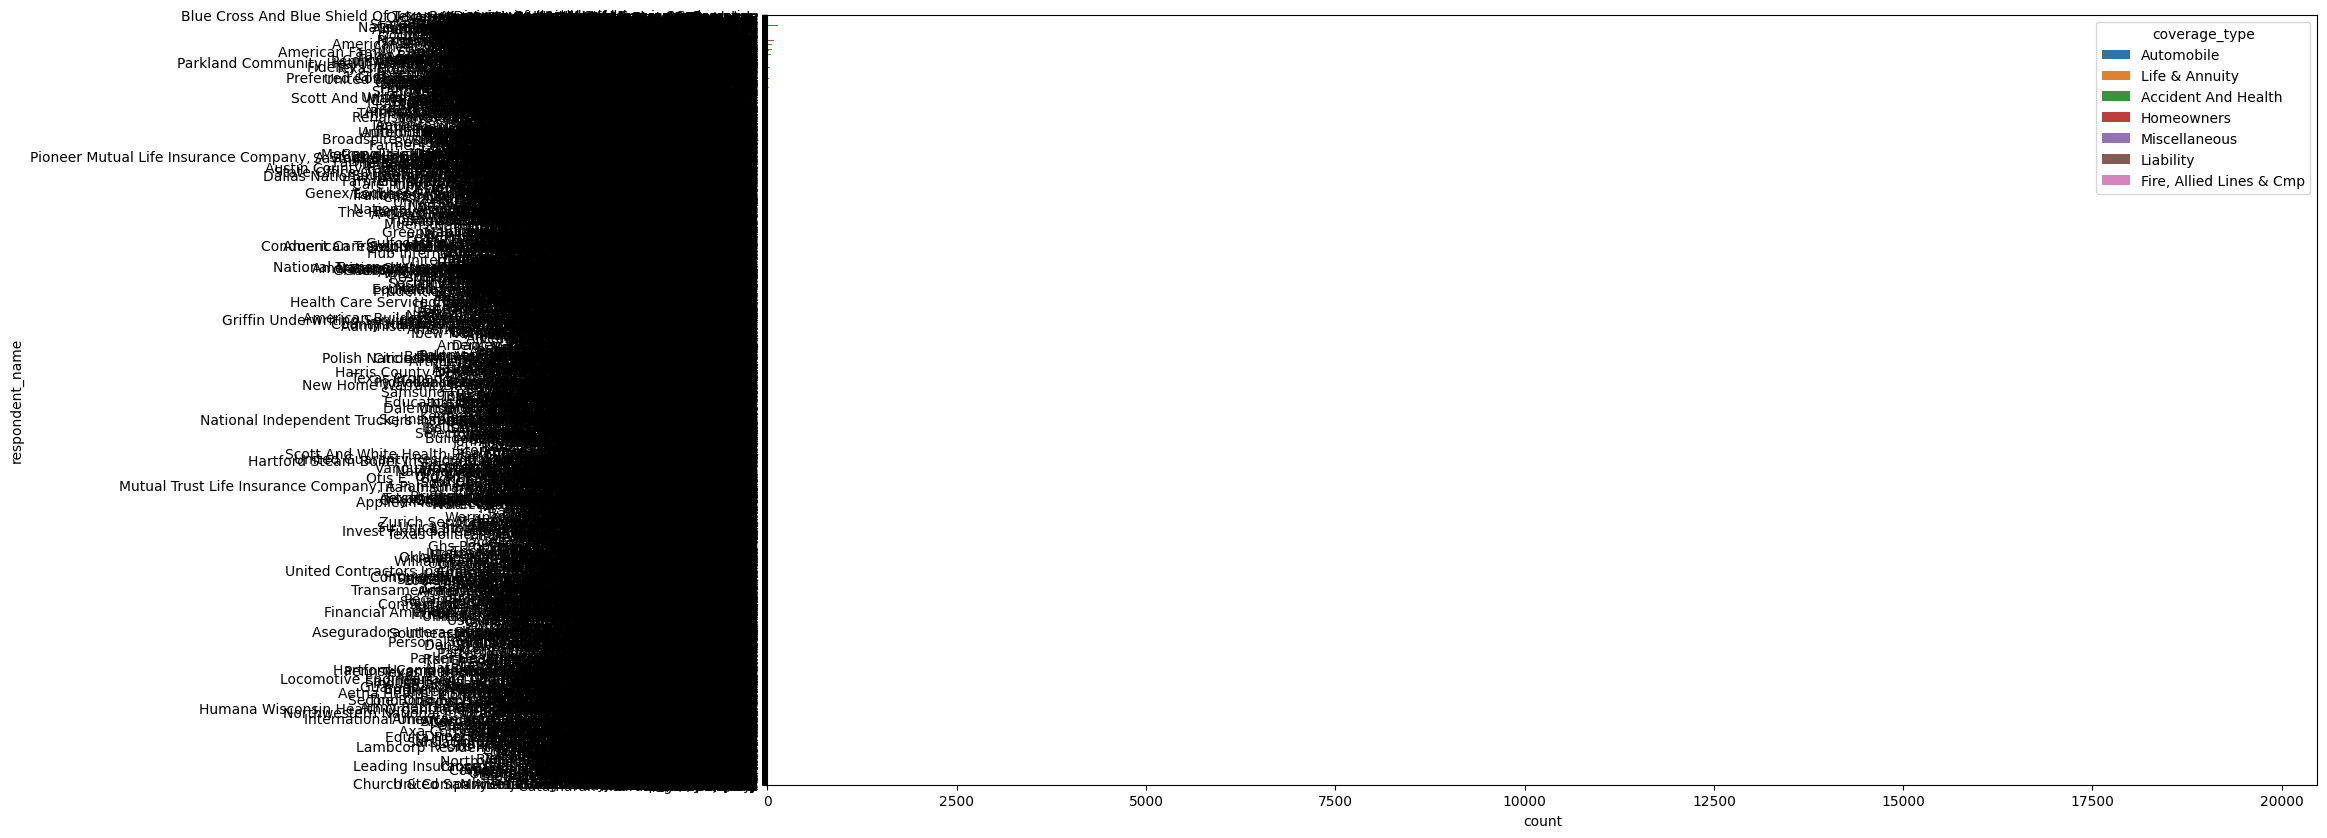

In [580]:
# Add a bar chart for the number of complaints by insurer and color by category.
plt.figure(figsize=(20,10))
sns.countplot(y='respondent_name', data=df, order=df['respondent_name'].value_counts().index, hue='coverage_type')



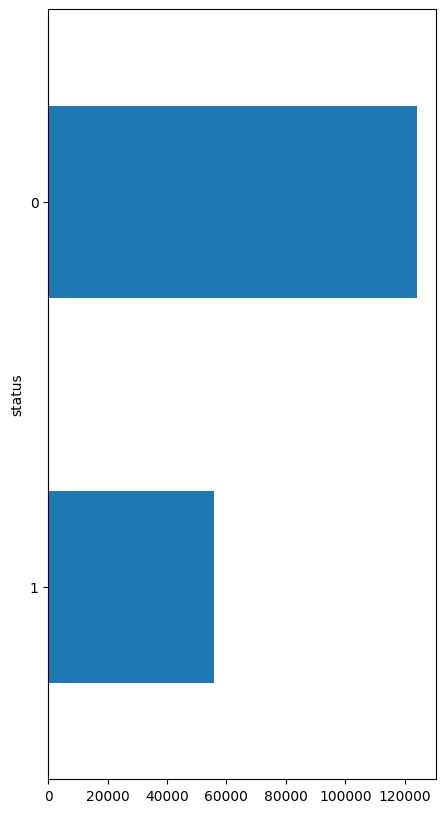

In [299]:
plt.figure(figsize=(5,10))
df.groupby('status')['complaint_number'].count().sort_values(ascending=True).plot.barh();

In [300]:
print("There are " + str(df['disposition'].nunique()) + " unique conclusions in data")

There are 2675 unique conclusions in data


14) Bar plot by 'Reason' and 'Recovery'(Log)

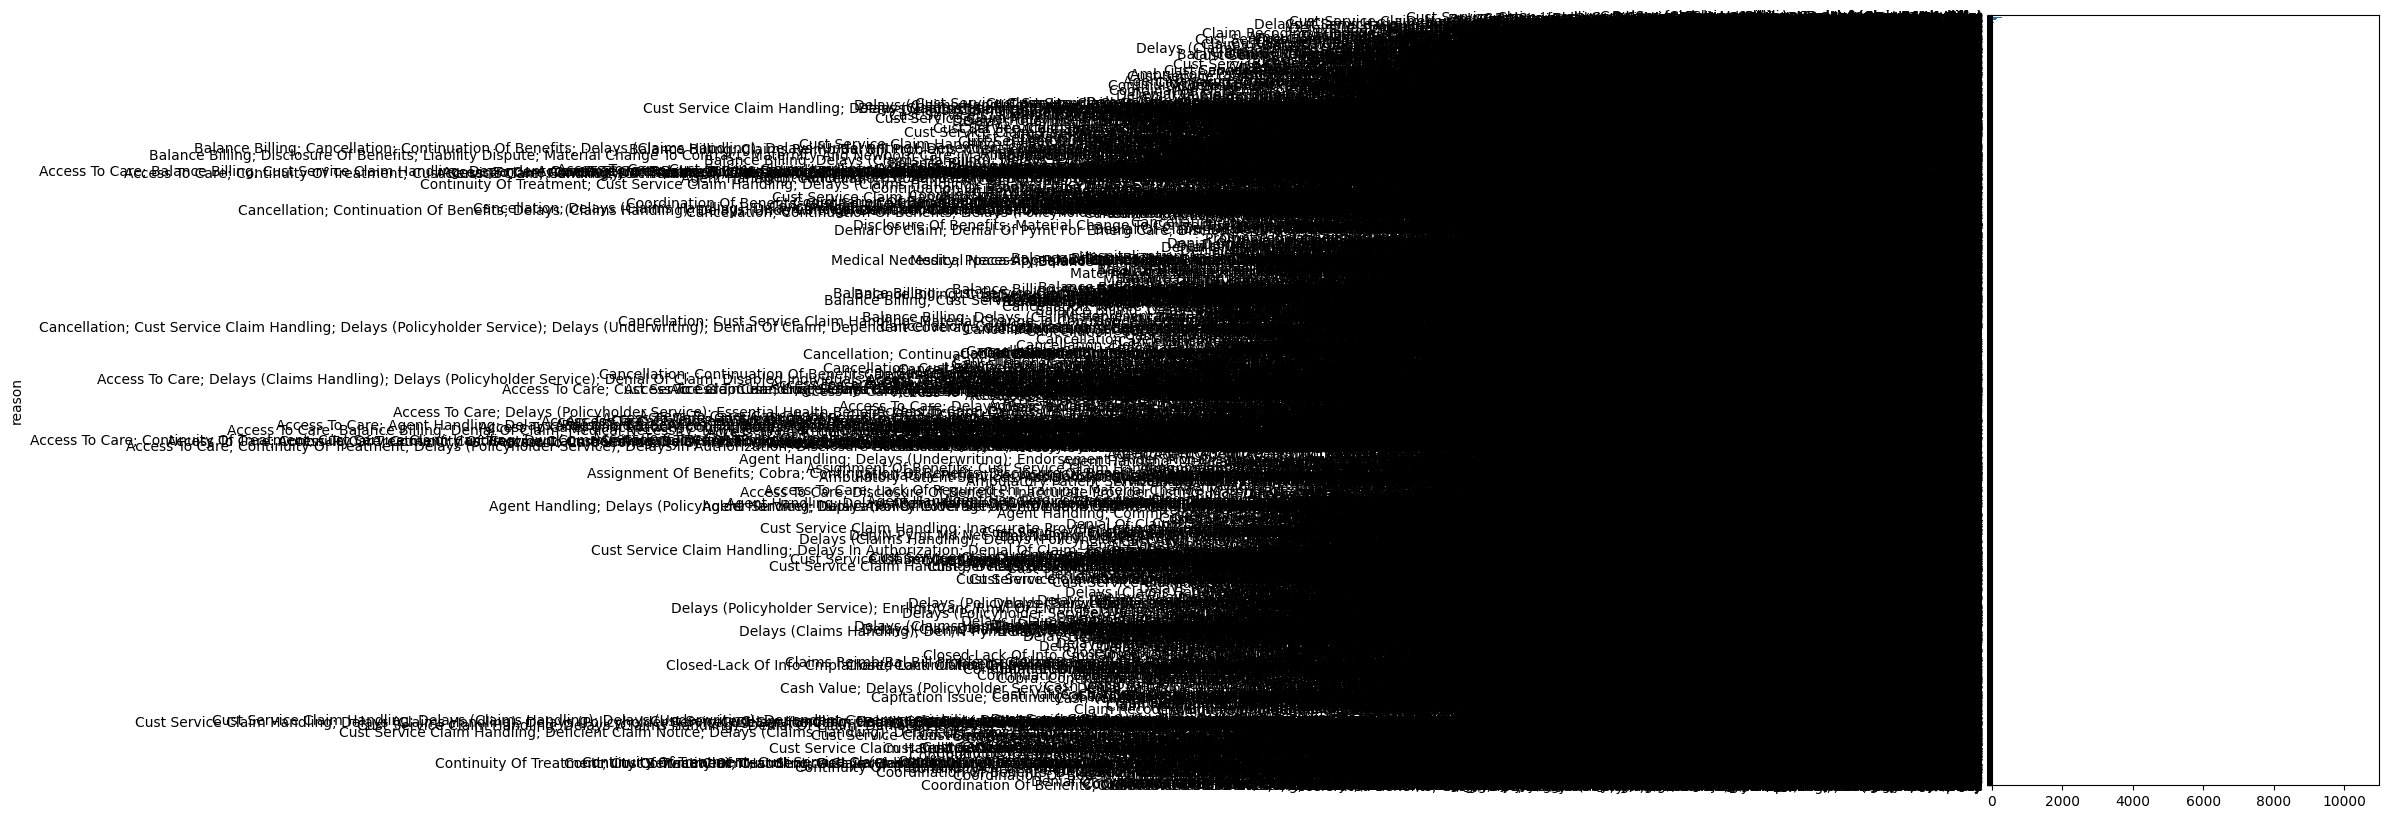

In [301]:
plt.figure(figsize=(5,10))
df.groupby('reason')['status'].sum().sort_values(ascending=True).plot.barh();

16) Scatter plot by 'Duration', 'Recovery'(Log) and 'Reason'

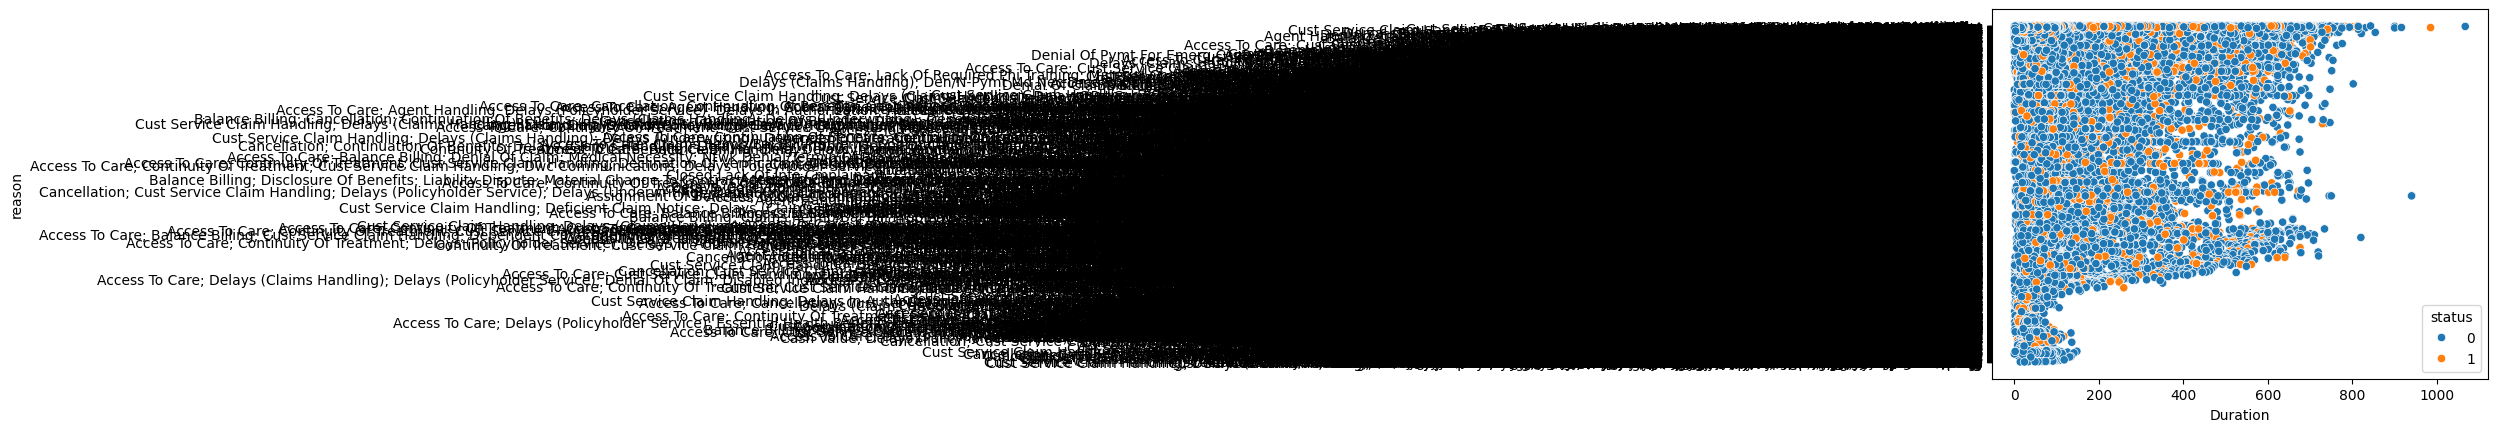

In [302]:
sns.scatterplot(data=df,x='Duration',y='reason',hue='status');

1) Rare Label Encoder

In [400]:
from feature_engine.encoding import RareLabelEncoder

In [304]:

# # Split the 'reason' column by semicolons and expand it into multiple rows
# expanded_df = df['reason'].str.split(';', expand=True)

# # Iterate through each expanded column to create a new DataFrame
# result = pd.DataFrame()

# for col in expanded_df.columns:
#     temp_df = df.copy()
#     temp_df['reason'] = expanded_df[col]
#     result = pd.concat([result, temp_df])

# # Drop rows where 'reason' is NaN (result of splitting empty parts)
# result = result.dropna(subset=['reason'])

# # Reset index for clarity
# result = result.reset_index(drop=True)

# # Print the resulting DataFrame

# df = result

In [403]:
df.head()

complaint_number                                    respondent_name  \
4                 5                 Charter Oak Fire Insurance Company   
5                 6            Reassure America Life Insurance Company   
6                 7                     Usaa General Indemnity Company   
7                 8  Blue Cross And Blue Shield Of Texas, A Divisio...   
11               12  Healthspring Life & Health Insurance Company, ...   

   complainant_role                         reason complaint_confirmed_code  \
4           Insured    Unsatisfactory Settle/Offer                       No   
5           Insured  Cash Value; Misrepresentation                       No   
6       Third Party    Unsatisfactory Settle/Offer                       No   
7           Insured                Denial Of Claim                       No   
11         Relative                Denial Of Claim                       No   

                                        disposition received_date closed_date  \
4   Contract Language/Legal Issue; Question Of Fact    2012-06-13  2012-07-17   
5                                   No Jurisdiction    2012-06-18  2012-07-30   
6                   Question Of Fact; Claim Settled    2012-02-27  2012-07-02   
7                           Company Position Upheld    2012-06-19  2012-08-06   
11                    Contract Language/Legal Issue    2012-06-18  2012-07-19   

               complaint_type        coverage_type  ...  \
4       Property And Casualty           Automobile  ...   
5   Life, Accident And Health       Life & Annuity  ...   
6       Property And Casualty           Automobile  ...   
7   Life, Accident And Health  Accident And Health  ...   
11  Life, Accident And Health  Accident And Health  ...   

                                              keyword Open_Year Open_Month  \
4   2012 North Texas Tornadoes; Adjuster'S Handlin...      2012          6   
5                                                 NaN      2012          6   
6                                    Claim Evaluation      2012          2   
7                                                 NaN      2012          6   
11                                                NaN      2012          6   

   Open_Day Close_Year Close_Month Close_Day  Duration  verdict_passed  status  
4        13       2012           7        17        34              No       0  
5        18       2012           7        30        42              No       0  
6        27       2012           7         2       126             Yes       1  
7        19       2012           8         6        48              No       0  
11       18       2012           7        19        31              No       0  

[5 rows x 26 columns]

1)-1 'Company' convert 3% or less to 'Others'

In [404]:
freq1=df['respondent_name'].value_counts(normalize=True)
print(freq1)

respondent_name
Blue Cross And Blue Shield Of Texas, A Division Of Health Care Service Corporation    0.108460
Unitedhealthcare Insurance Company                                                    0.078253
Aetna Life Insurance Company                                                          0.051835
United Healthcare Services, Inc.                                                      0.026434
Progressive County Mutual Insurance Company                                           0.026045
                                                                                        ...   
Bordman, Kenneth A                                                                    0.000006
Vergara, Maria D                                                                      0.000006
Chavez, Ninfa                                                                         0.000006
Catamaran Insurance Of Ohio, Inc.                                                     0.000006
Roman, Michael                    

In [405]:
freq1_cat=[x for x in freq1.loc[freq1 >0.03].index.values]

In [406]:
print(freq1_cat)

['Blue Cross And Blue Shield Of Texas, A Division Of Health Care Service Corporation', 'Unitedhealthcare Insurance Company', 'Aetna Life Insurance Company']


In [407]:
df['respondent_name']=np.where(
    df['respondent_name'].isin(freq1_cat),
    df['respondent_name'], 'Others'
)

1)-2 'Coverage' convert 3% or less to 'Others'

In [408]:
df.columns

Index(['complaint_number', 'respondent_name', 'complainant_role', 'reason',
       'complaint_confirmed_code', 'disposition', 'received_date',
       'closed_date', 'complaint_type', 'coverage_type', 'coverage_level',
       'respondent_id', 'respondent_role', 'respondent_type',
       'complainant_type', 'involved_party_type', 'keyword', 'Open_Year',
       'Open_Month', 'Open_Day', 'Close_Year', 'Close_Month', 'Close_Day',
       'Duration', 'verdict_passed', 'status'],
      dtype='object')

In [409]:
freq2=df['coverage_type'].value_counts(normalize=True)
print(freq2)

coverage_type
Accident And Health         0.487325
Automobile                  0.283383
Homeowners                  0.129161
Life & Annuity              0.053458
Miscellaneous               0.029229
Liability                   0.009384
Fire, Allied Lines & Cmp    0.008061
Name: proportion, dtype: float64


In [410]:
freq2_cat=[x for x in freq2.loc[freq2 >0.03].index.values]

In [411]:

print(freq2_cat)

['Accident And Health', 'Automobile', 'Homeowners', 'Life & Annuity']


In [412]:
df['coverage_type']=np.where(
    df['coverage_type'].isin(freq2_cat),
    df['coverage_type'], 'Others'
)

2) Convert coverage_level  5% or less to 'Others'

In [413]:
freq3=df['coverage_level'].value_counts(normalize=True)
print(freq3)

coverage_level
Group A&H                      0.337352
Individual Private Pass        0.261899
Individual A & H               0.149256
Homeowners                     0.116166
Individual Life                0.040013
                                 ...   
Federal Programs               0.000006
Xx-Commercial Multi-Peril      0.000006
Ocean Marine                   0.000006
In Home/Incidental Business    0.000006
Xx-Private Passenger Group     0.000006
Name: proportion, Length: 65, dtype: float64


In [414]:
freq3_cat=[x for x in freq3.loc[freq3 >0.05].index.values]

In [415]:
print(freq3_cat)

['Group A&H', 'Individual Private Pass', 'Individual A & H', 'Homeowners']


In [416]:
df['coverage_level']=np.where(
    df['coverage_level'].isin(freq3_cat),
    df['coverage_level'], 'Others'
)

'Disposition' convert 3% or less to 'Others'

In [417]:
freq4=df['disposition'].value_counts(normalize=True)
print(freq4)

disposition
Contract Language/Legal Issue                                                            0.142772
No Jurisdiction                                                                          0.130744
Information Furnished; Contract Language/Legal Issue                                     0.045157
Contract Language/Legal Issue; Information Furnished                                     0.044613
Claim Settled                                                                            0.031996
                                                                                           ...   
Appraisal Process Invoked; Referred For Disciplinary Actn; Additional Monies Received    0.000006
Cancel/Non-Renewal Upheld; Question Of Fact; Company Position Upheld                     0.000006
Out-Of-Net/Mediation/Settl_Exp; Contract Language/Legal Issue; Information Furnished     0.000006
Premium Refunded; Complainant Retained Attorney; Contract Language/Legal Issue           0.000006
Clean Cl

In [418]:
freq4_cat=[x for x in freq4.loc[freq4 >0.03].index.values]

In [419]:
print(freq4_cat)

['Contract Language/Legal Issue', 'No Jurisdiction', 'Information Furnished; Contract Language/Legal Issue', 'Contract Language/Legal Issue; Information Furnished', 'Claim Settled']


In [420]:
df['disposition']=np.where(
    df['disposition'].isin(freq4_cat),
    df['disposition'], 'Others'
)

In [421]:
df.head()

complaint_number                                    respondent_name  \
4                 5                                             Others   
5                 6                                             Others   
6                 7                                             Others   
7                 8  Blue Cross And Blue Shield Of Texas, A Divisio...   
11               12                                             Others   

   complainant_role                         reason complaint_confirmed_code  \
4           Insured    Unsatisfactory Settle/Offer                       No   
5           Insured  Cash Value; Misrepresentation                       No   
6       Third Party    Unsatisfactory Settle/Offer                       No   
7           Insured                Denial Of Claim                       No   
11         Relative                Denial Of Claim                       No   

                      disposition received_date closed_date  \
4                          Others    2012-06-13  2012-07-17   
5                 No Jurisdiction    2012-06-18  2012-07-30   
6                          Others    2012-02-27  2012-07-02   
7                          Others    2012-06-19  2012-08-06   
11  Contract Language/Legal Issue    2012-06-18  2012-07-19   

               complaint_type        coverage_type  ...  \
4       Property And Casualty           Automobile  ...   
5   Life, Accident And Health       Life & Annuity  ...   
6       Property And Casualty           Automobile  ...   
7   Life, Accident And Health  Accident And Health  ...   
11  Life, Accident And Health  Accident And Health  ...   

                                              keyword Open_Year Open_Month  \
4   2012 North Texas Tornadoes; Adjuster'S Handlin...      2012          6   
5                                                 NaN      2012          6   
6                                    Claim Evaluation      2012          2   
7                                                 NaN      2012          6   
11                                                NaN      2012          6   

   Open_Day Close_Year Close_Month Close_Day  Duration  verdict_passed  status  
4        13       2012           7        17        34              No       0  
5        18       2012           7        30        42              No       0  
6        27       2012           7         2       126             Yes       1  
7        19       2012           8         6        48              No       0  
11       18       2012           7        19        31              No       0  

[5 rows x 26 columns]

 'Keyword' convert 3% or less to 'Others', convert missing to others

In [422]:
freq5=df['keyword'].value_counts(normalize=True)
print(freq5)

keyword
Claim Evaluation                                                                           0.215735
Claim Evaluation; Med Provider/Thirdparty Biller                                           0.066260
Adjuster'S Handling                                                                        0.063338
Underwriting Criteria                                                                      0.036238
Adjuster'S Handling; Claim Evaluation                                                      0.035632
                                                                                             ...   
Claim Evaluation; Hail; Policy Exclusion; Water Damage                                     0.000007
Adjuster'S Handling; Claim Evaluation; Hail; Loss Of Use; Total Loss                       0.000007
Claim Evaluation; Coverage Dispute; Network Adequacy                                       0.000007
Adjuster'S Handling; Appraisal; Claim Evaluation; Engineer'S Report; Roof; Water Damage    0

In [423]:
freq5_cat=[x for x in freq5.loc[freq5 >0.03].index.values]

In [424]:
print(freq5_cat)

['Claim Evaluation', 'Claim Evaluation; Med Provider/Thirdparty Biller', "Adjuster'S Handling", 'Underwriting Criteria', "Adjuster'S Handling; Claim Evaluation", 'Claim Evaluation; Out-Of-Ntwk Prvdr Mediation Rq']


In [425]:
df['keyword'] = df['keyword'].fillna('Others')
df['keyword'] = np.where(
    df['keyword'].isin(freq5_cat),
    df['keyword'], 'Others'
)

### 2) WoE Encoder

In [426]:
from feature_engine.encoding import WoEEncoder

In [427]:
df.columns

Index(['complaint_number', 'respondent_name', 'complainant_role', 'reason',
       'complaint_confirmed_code', 'disposition', 'received_date',
       'closed_date', 'complaint_type', 'coverage_type', 'coverage_level',
       'respondent_id', 'respondent_role', 'respondent_type',
       'complainant_type', 'involved_party_type', 'keyword', 'Open_Year',
       'Open_Month', 'Open_Day', 'Close_Year', 'Close_Month', 'Close_Day',
       'Duration', 'verdict_passed', 'status'],
      dtype='object')

In [428]:
df=df.fillna({'respondent_name':'Others','coverage_type':'Others','coverage_level':'Others',
           'reason':'Others','keyword':'Others','disposition':'Others'})

In [429]:
variables=['respondent_name','coverage_type','coverage_level','reason','keyword','disposition']

In [430]:
woe_enc=WoEEncoder(variables=variables)

In [431]:
df.columns

Index(['complaint_number', 'respondent_name', 'complainant_role', 'reason',
       'complaint_confirmed_code', 'disposition', 'received_date',
       'closed_date', 'complaint_type', 'coverage_type', 'coverage_level',
       'respondent_id', 'respondent_role', 'respondent_type',
       'complainant_type', 'involved_party_type', 'keyword', 'Open_Year',
       'Open_Month', 'Open_Day', 'Close_Year', 'Close_Month', 'Close_Day',
       'Duration', 'verdict_passed', 'status'],
      dtype='object')

In [432]:
# find NaN in X
df.isnull().sum()

complaint_number                0
respondent_name                 0
complainant_role                0
reason                          0
complaint_confirmed_code        5
disposition                     0
received_date                   0
closed_date                     0
complaint_type                  1
coverage_type                   0
coverage_level                  0
respondent_id                   0
respondent_role                 0
respondent_type                 0
complainant_type                0
involved_party_type         18259
keyword                         0
Open_Year                       0
Open_Month                      0
Open_Day                        0
Close_Year                      0
Close_Month                     0
Close_Day                       0
Duration                        0
verdict_passed                  0
status                          0
dtype: int64

In [433]:
# drop rows with NaN in X
df = df.dropna()

In [434]:
df['closed_date'] = df.closed_date.astype('int64')
df['received_date'] = df.received_date.astype('int64')

In [475]:
X=df.drop(['status','complaint_number','disposition','keyword','closed_date','received_date','Duration',
           'Open_Year', 'Open_Month', 'Open_Day', 'Close_Year', 'Close_Month', 'Close_Day', 'verdict_passed',
           'respondent_id'],axis=1)
y=df['status']

In [476]:
X

respondent_name             complainant_role  \
6               Others                  Third Party   
11              Others                     Relative   
12              Others                      Insured   
17              Others                  Third Party   
27              Others                  Third Party   
...                ...                          ...   
259683          Others                  Third Party   
259685          Others  Third Party Billing Service   
259686          Others                     Provider   
259689          Others                      Insured   
259692          Others                  Third Party   

                                                   reason  \
6                             Unsatisfactory Settle/Offer   
11                                        Denial Of Claim   
12                                           Cancellation   
17              Delays (Claims Handling); Denial Of Claim   
27                            Unsatisfactory Settle/Offer   
...                                                   ...   
259683  Cust Service Claim Handling; Delays (Claims Ha...   
259685                                    Denial Of Claim   
259686                        Cust Service Claim Handling   
259689                                 Premium And Rating   
259692                 Not Within Tdi Jurisdiction; Other   

       complaint_confirmed_code             complaint_type  \
6                            No      Property And Casualty   
11                           No  Life, Accident And Health   
12                           No      Property And Casualty   
17                           No      Property And Casualty   
27                           No      Property And Casualty   
...                         ...                        ...   
259683                       No      Property And Casualty   
259685                       No  Life, Accident And Health   
259686                       No  Life, Accident And Health   
259689                       No      Property And Casualty   
259692                       No      Property And Casualty   

              coverage_type           coverage_level  \
6                Automobile  Individual Private Pass   
11      Accident And Health         Individual A & H   
12               Automobile  Individual Private Pass   
17               Automobile  Individual Private Pass   
27               Automobile  Individual Private Pass   
...                     ...                      ...   
259683           Automobile  Individual Private Pass   
259685  Accident And Health         Individual A & H   
259686  Accident And Health                Group A&H   
259689           Homeowners               Homeowners   
259692           Automobile  Individual Private Pass   

                 respondent_role respondent_type complainant_type  \
6       Ins Co - Licensed/Active    Organization             Indv   
11      Ins Co - Licensed/Active    Organization             Indv   
12      Ins Co - Licensed/Active    Organization             Indv   
17      Ins Co - Licensed/Active    Organization             Indv   
27      Ins Co - Licensed/Active    Organization             Indv   
...                          ...             ...              ...   
259683  Ins Co - Licensed/Active    Organization             Indv   
259685       Self-Funded / Erisa    Organization              Org   
259686  Ins Co - Licensed/Active    Organization              Org   
259689  Ins Co - Licensed/Active    Organization             Indv   
259692                     Other      Individual             Indv   

                                      involved_party_type  
6                                                 Insured  
11                           Gr Elected Official; Insured  
12                              Associated Subject Agency  
17                                       Associated Agent  
27                              Associated Subject Agency  
...   

In [477]:
import pandas as pd
from feature_engine.encoding import WoEEncoder

# Combine rare categories into a single category
def combine_rare_categories(df, column, threshold=0.01):
    freq = df[column].value_counts(normalize=True)
    rare_categories = freq[freq < threshold].index
    df[column] = df[column].apply(lambda x: 'Other' if x in rare_categories else x)
    return df

# Apply the function to the 'reason' and 'disposition' columns

problematic_columns = ['complainant_role','reason', 'complaint_type', 'respondent_role', 'involved_party_type']
for col in problematic_columns:
    X = combine_rare_categories(X, col)
# X = combine_rare_categories(X, 'reason')
# X = combine_rare_categories(X, 'disposition')



In [478]:
# Initialize the WoEEncoder
woe_enc = WoEEncoder()

# Fit the WoEEncoder
woe_enc.fit(X, y)

WoEEncoder()

## Modeling

1) Get Dummies

In [479]:
#strip the white space in all columns
# Convert all columns to propercase if they are strings
X = X.apply(lambda x: x.str.title() if x.dtype == "object" else x)
X = X.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [480]:
X=pd.get_dummies(X)

In [481]:
# save column names of X into a file by splitting by column names and values
with open('columns.txt', 'w') as f:
    for col in X.columns:
        f.write(col + '\n')


In [442]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161730 entries, 6 to 259692
Data columns (total 76 columns):
 #   Column                                                                                                      Non-Null Count   Dtype
---  ------                                                                                                      --------------   -----
 0   respondent_name_Aetna Life Insurance Company                                                                161730 non-null  bool 
 1   respondent_name_Blue Cross And Blue Shield Of Texas, A Division Of Health Care Service Corporation          161730 non-null  bool 
 2   respondent_name_Others                                                                                      161730 non-null  bool 
 3   respondent_name_Unitedhealthcare Insurance Company                                                          161730 non-null  bool 
 4   complainant_role_Attorney                                                

### Set Logistic Regression as the baseline model

In [581]:


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=500)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("--------------------")
print(f'Accuracy: {accuracy}')
print("--------------------")
print('Confusion Matrix:')
print(conf_matrix)
print("--------------------")
print('Classification Report:')
print(class_report)
print("--------------------")

--------------------
Accuracy: 0.7863341056744355
--------------------
Confusion Matrix:
[[25815  7210]
 [ 6899 26109]]
--------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79     33025
         1.0       0.78      0.79      0.79     33008

    accuracy                           0.79     66033
   macro avg       0.79      0.79      0.79     66033
weighted avg       0.79      0.79      0.79     66033

--------------------


In [582]:
#length of x_train  
print(len(X_train))
len(X_test)

154077


66033

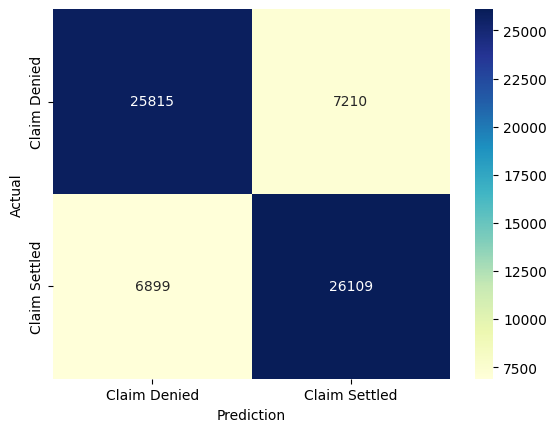

In [583]:
cm_matrix = pd.DataFrame(data=conf_matrix, columns=['Claim Denied', 'Claim Settled'], 
                                 index=['Claim Denied', 'Claim Settled'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Prediction", fontsize=10)
plt.ylabel("Actual", fontsize=10);

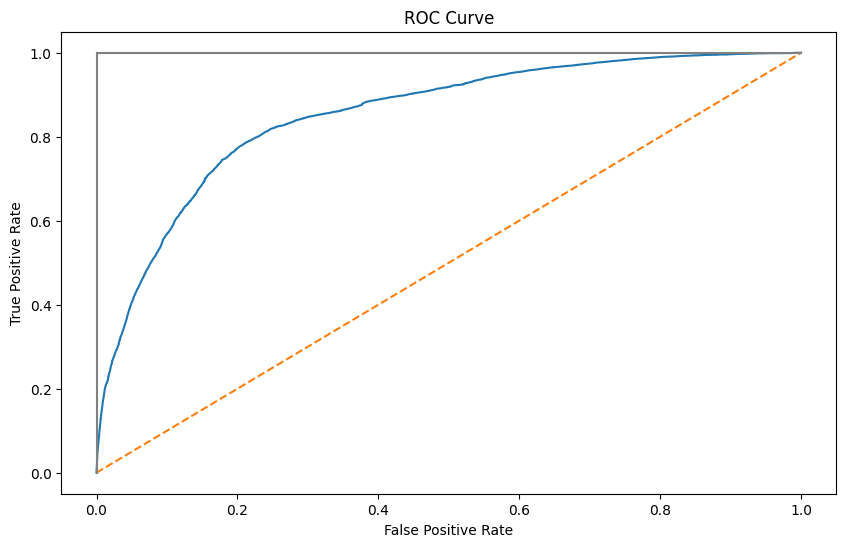

In [ ]:
# Visualize the rOC curve
from sklearn.metrics import roc_curve

# Get the predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:,1]

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls='--')
plt.plot([0, 0], [1, 0], c='.5')
plt.plot([1, 1], c='.5')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


2) Split Train and Test

In [585]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [586]:
from sklearn.model_selection import StratifiedKFold

# Define the cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Fit the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [587]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# Get the cross-validation scores
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean cross-validation score
print("Mean cross-validation score:", scores.mean())

# Get the test accuracy
test_accuracy = model.score(X_test, y_test)
print("Test accuracy:", test_accuracy)

# Get the validation accuracy
val_accuracy = model.score(X_val, y_val)
print("Validation accuracy:", val_accuracy)

# Get the feature importances
importances = model.feature_importances_

# Get the indices of the features sorted by importance
indices = np.argsort(importances)[::-1]

# Get the indices of features whose importance is greater than 0.01
important_indices = [i for i in indices if importances[i] > 0.001]

# filter out the non important features
important_features = X.columns[important_indices]

important_features



Cross-validation scores: [0.8036716  0.80473784 0.80339344 0.80236439 0.80421882]
Mean cross-validation score: 0.803677220186523
Test accuracy: 0.8055063377402208
Validation accuracy: 0.8029595015576324


Index(['complaint_confirmed_code_Yes', 'complaint_confirmed_code_No',
       'reason_Other', 'reason_Denial Of Claim', 'coverage_type_Automobile',
       'reason_Delays (Claims Handling)',
       'respondent_role_Self-Funded / Erisa',
       'reason_Cust Service Claim Handling; Delays (Claims Handling)',
       'respondent_role_Ins Co - Licensed/Active',
       'complainant_role_Third Party',
       'complaint_type_Life, Accident And Health',
       'complaint_type_Property And Casualty',
       'reason_Balance Billing; Unsatisfactory Settle/Offer',
       'involved_party_type_Other', 'complainant_role_Insured',
       'coverage_level_Individual Private Pass', 'reason_Premium And Rating',
       'complainant_role_Third Party Billing Service',
       'reason_Unsatisfactory Settle/Offer', 'respondent_name_Others',
       'involved_party_type_Associated Subject Company; Out-Of-Net Anesthesiologist',
       'reason_Delays (Claims Handling); Unsatisfactory Settle/Offer',
       'complainant

--------------------
Accuracy: 0.8055063377402208
--------------------
Confusion Matrix:
[[26207  6818]
 [ 6025 26983]]
--------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80     33025
         1.0       0.80      0.82      0.81     33008

    accuracy                           0.81     66033
   macro avg       0.81      0.81      0.81     66033
weighted avg       0.81      0.81      0.81     66033

--------------------


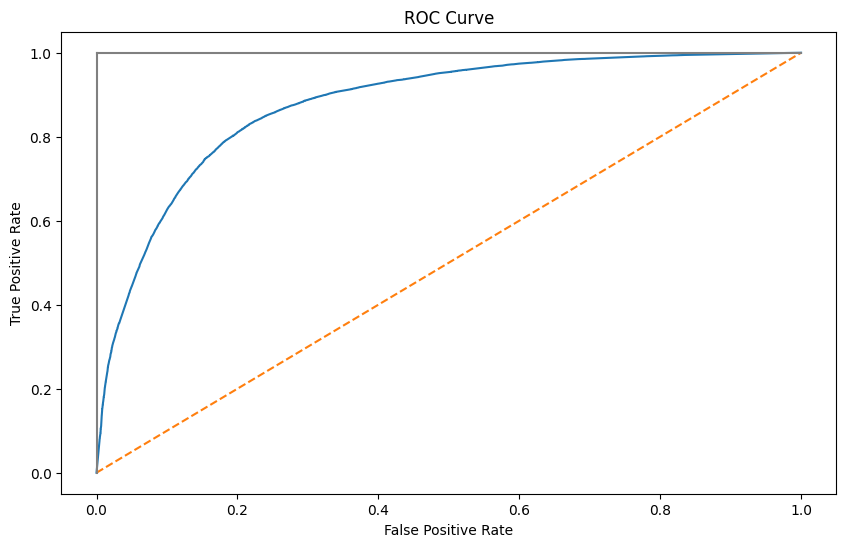

In [591]:
# Evaluate the model

# print confusion matrix
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("--------------------")
print(f'Accuracy: {accuracy}')
print("--------------------")
print('Confusion Matrix:')
print(conf_matrix)
print("--------------------")
print('Classification Report:')
print(class_report)
print("--------------------")

# Roc Curve
from sklearn.metrics import roc_curve

# Get the predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:,1]

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls='--')
plt.plot([0, 0], [1, 0], c='.5')
plt.plot([1, 1], c='.5')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()



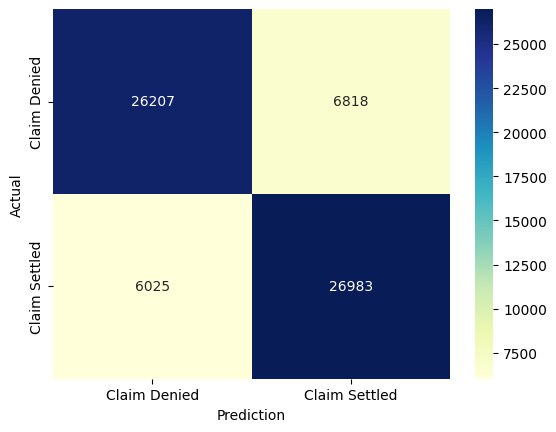

In [589]:

cm_matrix = pd.DataFrame(data=conf_matrix, columns=['Claim Denied', 'Claim Settled'], 
                                 index=['Claim Denied', 'Claim Settled'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Prediction", fontsize=10)
plt.ylabel("Actual", fontsize=10);

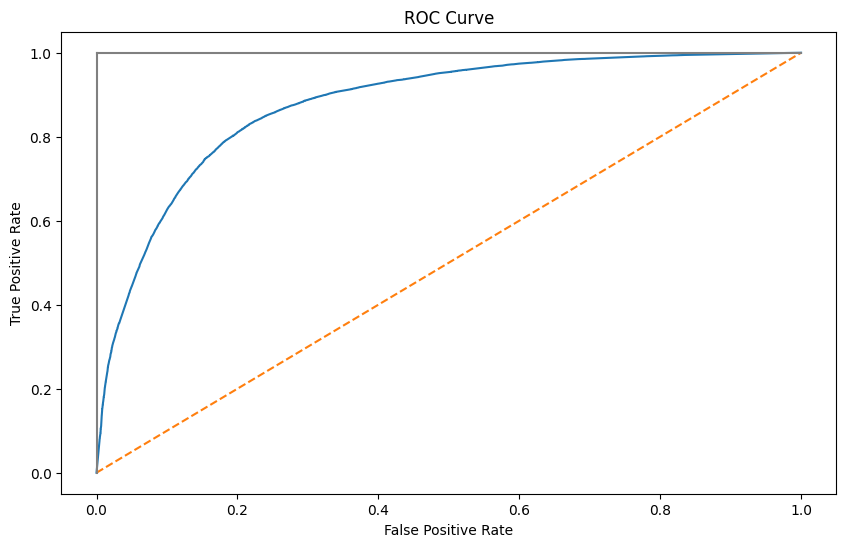

In [590]:
# Visualize the rOC curve
from sklearn.metrics import roc_curve

# Get the predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:,1]

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls='--')
plt.plot([0, 0], [1, 0], c='.5')
plt.plot([1, 1], c='.5')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Feature ranking:
complaint_confirmed_code_Yes: 0.13735417542091174
complaint_confirmed_code_No: 0.1191525684728917
reason_Other: 0.052575926148794035
reason_Denial Of Claim: 0.038637790343090554
coverage_type_Automobile: 0.03267129758602101
reason_Delays (Claims Handling): 0.0324609277117728
respondent_role_Self-Funded / Erisa: 0.029588504836317545
reason_Cust Service Claim Handling; Delays (Claims Handling): 0.028936568804189572
respondent_role_Ins Co - Licensed/Active: 0.02791924010390772
complainant_role_Third Party: 0.02559231656950982
complaint_type_Life, Accident And Health: 0.022713312621138897
complaint_type_Property And Casualty: 0.022525041490521792
reason_Balance Billing; Unsatisfactory Settle/Offer: 0.022319551157359393
involved_party_type_Other: 0.018599882763126737
complainant_role_Insured: 0.017266190447439392
coverage_level_Individual Private Pass: 0.01635284817035029
reason_Premium And Rating: 0.01435591993893475
complainant_role_Third Party Billing Service: 0.01404131

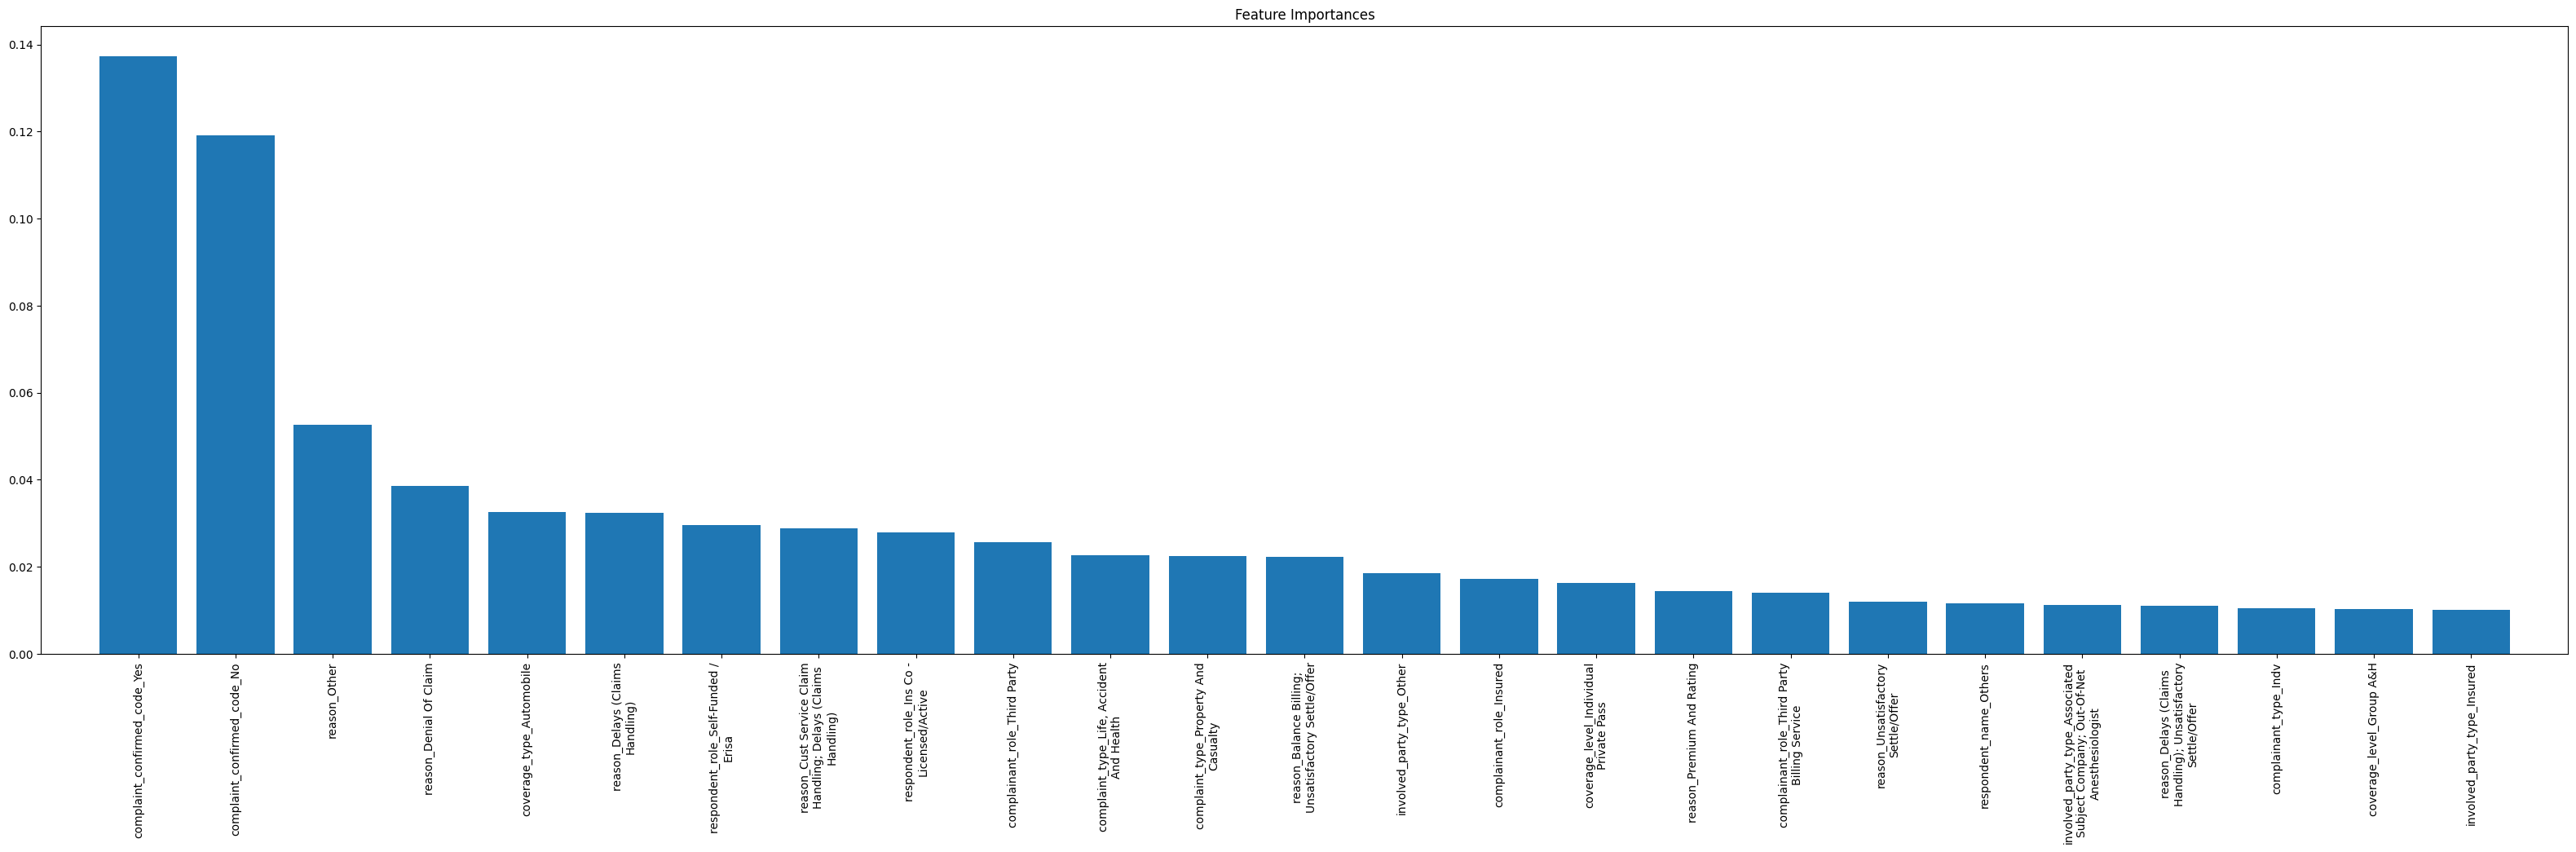

In [592]:
import textwrap

import matplotlib.pyplot as plt

# Get the feature importances
importances = model.feature_importances_

# Get the indices of the features sorted by importance
indices = np.argsort(importances)[::-1]

# Get the indices of features whose importance is greater than 0.01
important_indices = [i for i in indices if importances[i] > 0.01]

# Filter out the non-important features
important_features = X.columns[important_indices]

# Print the feature ranking
print("Feature ranking:")
for i in important_indices:
    print(f"{X.columns[i]}: {importances[i]}")

# Wrap the text of tick labels
wrapped_labels = [textwrap.fill(label, 30) for label in X.columns[important_indices]]

# Plot the feature importances
plt.figure(figsize=(40, 10))
plt.title("Feature Importances")
plt.bar(range(len(important_indices)), importances[important_indices], align="center")
plt.xticks(range(len(important_indices)), wrapped_labels, rotation=90)
plt.xlim([-1, len(important_indices)])
plt.show()

### Suport Vector Machines

In [593]:

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier

# Initialize the SVM model
svm_model = LinearSVC()

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Predict on the test data
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


print("--------------------")
print(f'Accuracy: {accuracy}')
print("--------------------")
print('Confusion Matrix:')
print(conf_matrix)
print("--------------------")
print('Classification Report:')
print(class_report)
print("--------------------")

--------------------
Accuracy: 0.7864855451062348
--------------------
Confusion Matrix:
[[25739  7286]
 [ 6813 26195]]
--------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79     33025
         1.0       0.78      0.79      0.79     33008

    accuracy                           0.79     66033
   macro avg       0.79      0.79      0.79     66033
weighted avg       0.79      0.79      0.79     66033

--------------------


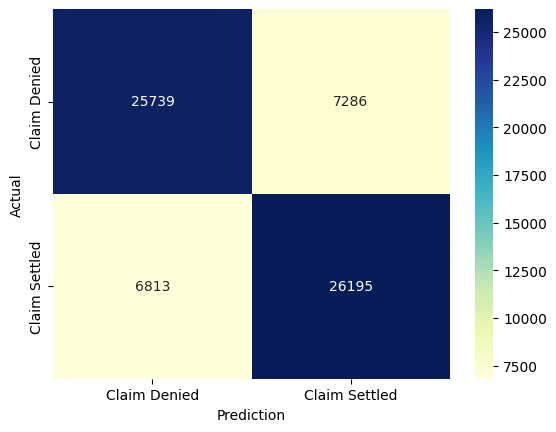

In [594]:

cm_matrix = pd.DataFrame(data=conf_matrix, columns=['Claim Denied', 'Claim Settled'], 
                                 index=['Claim Denied', 'Claim Settled'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Prediction", fontsize=10)
plt.ylabel("Actual", fontsize=10);

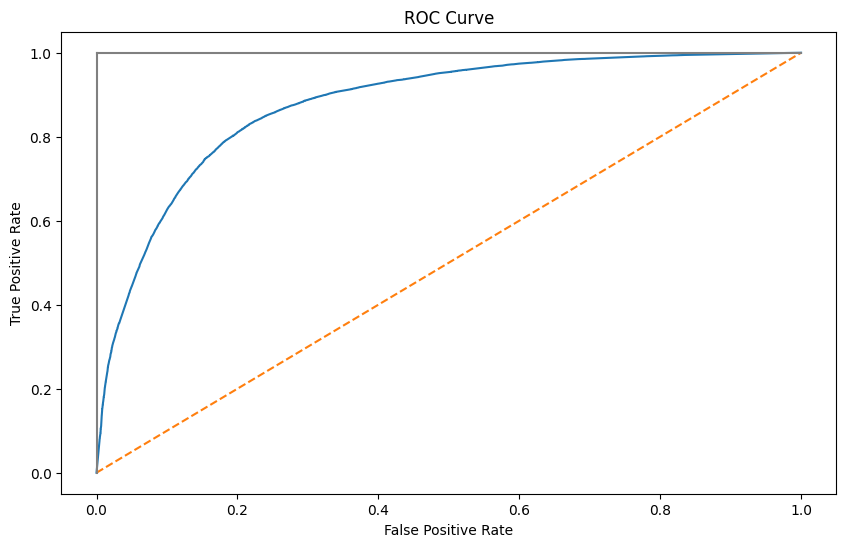

In [595]:
# Visualize the rOC curve
from sklearn.metrics import roc_curve

# Get the predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:,1]

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls='--')
plt.plot([0, 0], [1, 0], c='.5')
plt.plot([1, 1], c='.5')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## LGBMC 

In [454]:
y_train

94714     0
88129     1
35601     1
103648    0
177087    0
         ..
26809     0
253522    0
86982     1
33272     0
207422    1
Name: status, Length: 79247, dtype: int64

In [455]:
# X=df.drop(['status','complaint_number','disposition','keyword','closed_date','received_date',
#            'Open_Year', 'Open_Month', 'Open_Day', 'Close_Year', 'Close_Month', 'Close_Day', 'verdict_passed',
#            'respondent_id'],axis=1)
# y=df['status']

In [596]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [597]:
X_train

respondent_name_Aetna Life Insurance Company  \
107191                                           0.0   
103889                                           0.0   
88936                                            0.0   
25134                                            0.0   
51024                                            0.0   
...                                              ...   
82841                                            0.0   
13960                                            0.0   
182461                                           0.0   
37038                                            0.0   
51125                                            0.0   

        respondent_name_Blue Cross And Blue Shield Of Texas, A Division Of Health Care Service Corporation  \
107191                                                0.0                                                    
103889                                                0.0                                                    
88936                                                 1.0                                                    
25134                                                 0.0                                                    
51024                                                 1.0                                                    
...                                                   ...                                                    
82841                                                 0.0                                                    
13960                                                 0.0                                                    
182461                                                0.0                                                    
37038                                                 0.0                                                    
51125                                                 1.0                                                    

        respondent_name_Others  \
107191                     1.0   
103889                     0.0   
88936                      0.0   
25134                      0.0   
51024                      0.0   
...                        ...   
82841                      0.0   
13960                      0.0   
182461                     1.0   
37038                      1.0   
51125                      0.0   

        respondent_name_Unitedhealthcare Insurance Company  \
107191                                                0.0    
103889                                                1.0    
88936                                                 0.0    
25134                                                 1.0    
51024                                                 0.0    
...                                                   ...    
82841                                                 1.0    
13960                                                 1.0    
182461                                                0.0    
37038                                                 0.0    
51125                                                 0.0    

        complainant_role_Attorney  complainant_role_Beneficiary  \
107191                        0.0                           0.0   
103889                        0.0                           0.0   
88936                         0.0                           0.0   
25134                         0.0                           0.0   
51024                         0.0                           0.0   
...                           ...                           ...   
82841                         0.0                           0.0   
13960                         0.0                           0.0   
182461                        1.0                           0.0   
37038                         0.0                           0.0   
51125                         0.0                           0.0   

        complainant_role_Consumer (Non-Insured)  compla

In [598]:
# Convert data to float32
X = X.astype(np.float32)
y = y.astype(np.float32)
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)


In [599]:
X=pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [600]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re


# Replace any special characters in column names with underscores
X_train = X_train.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
X_test = X_test.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x)) 

# Convert boolean columns to integers after renaming columns
# SMOTE expects numerical features. It doesn't work with boolean directly
for column in X_train.columns: # Changed to iterate through X_train instead of X
    if X_train[column].dtype == bool:
        X_train[column] = X_train[column].astype(int)
for column in X_test.columns: # Added loop to convert boolean in X_test as well
    if X_test[column].dtype == bool:
        X_test[column] = X_test[column].astype(int)

# Apply SMOTE to the data
# smote = SMOTE(sampling_strategy='minority')
# X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Initialize the model
model = LGBMClassifier()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print the accuracy score
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 53913, number of negative: 53940
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4529
[LightGBM] [Info] Number of data points in the train set: 107853, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499875 -> initscore=-0.000501
[LightGBM] [Info] Start training from score -0.000501
Accuracy Score:  0.8098829373192192

Confusion Matrix:
 [[26409  6616]
 [ 5938 27070]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.80      0.81     33025
         1.0       0.80      0.82      0.81     33008

    accuracy                           0.81     66033
   macro avg       0.81      0.81      0.81     66033
weighted avg       0.81      0.81      0.81     66033



--------------------
Accuracy: 0.8098829373192192
--------------------
Confusion Matrix:
[[26409  6616]
 [ 5938 27070]]
--------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81     33025
         1.0       0.80      0.82      0.81     33008

    accuracy                           0.81     66033
   macro avg       0.81      0.81      0.81     66033
weighted avg       0.81      0.81      0.81     66033

--------------------


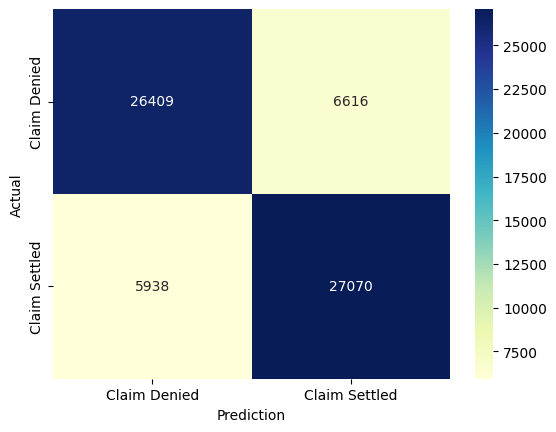

In [601]:


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


print("--------------------")
print(f'Accuracy: {accuracy}')
print("--------------------")
print('Confusion Matrix:')
print(conf_matrix)
print("--------------------")
print('Classification Report:')
print(class_report)
print("--------------------")

cm_matrix = pd.DataFrame(data=conf_matrix, columns=['Claim Denied', 'Claim Settled'], 
                                 index=['Claim Denied', 'Claim Settled'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Prediction", fontsize=10)
plt.ylabel("Actual", fontsize=10);

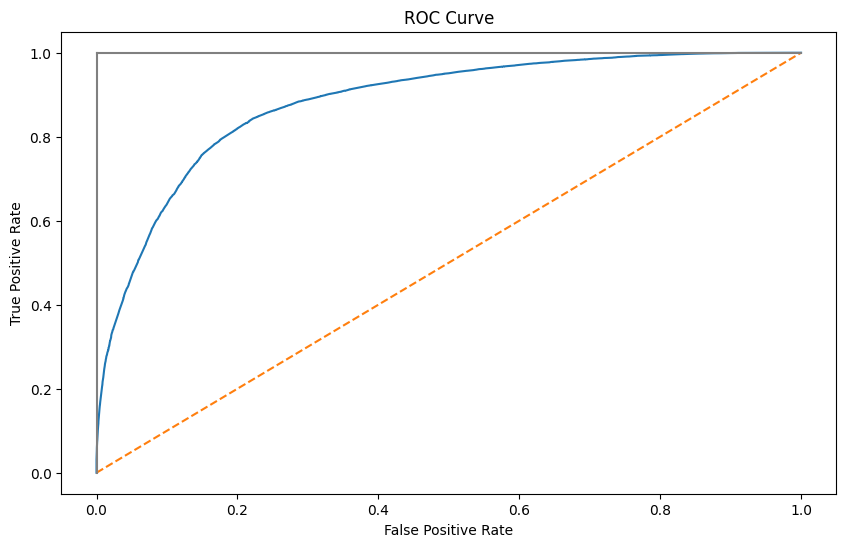

In [602]:
# plot roc curve
from sklearn.metrics import roc_curve

# Get the predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:,1]

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls='--')
plt.plot([0, 0], [1, 0], c='.5')
plt.plot([1, 1], c='.5')
plt.title('ROC Curve')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


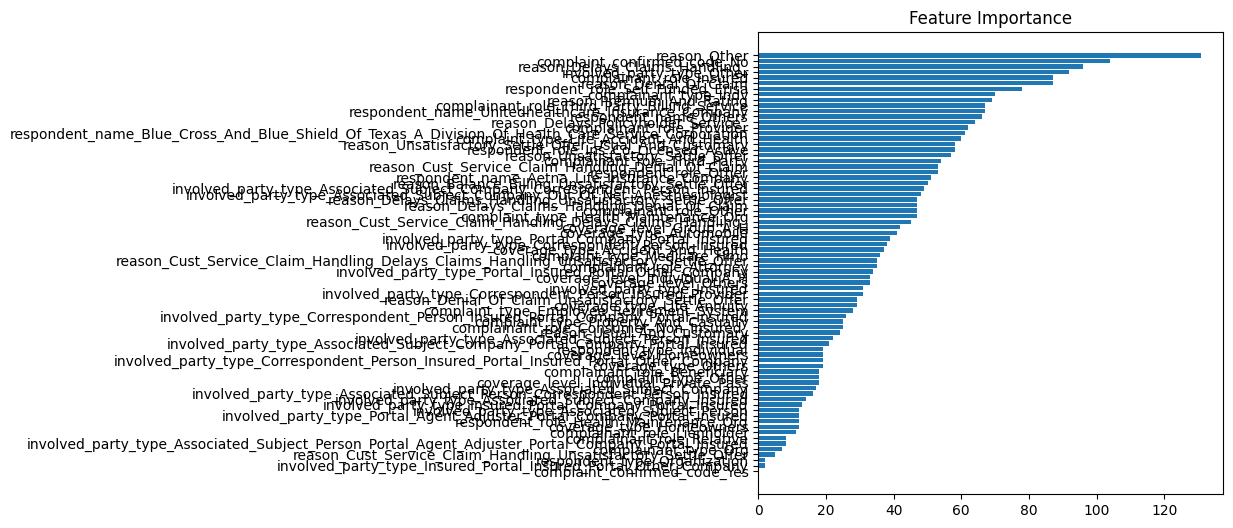

In [462]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(6, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

Cat Boost Classifier

In [603]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(iterations=200)
cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)
conf = confusion_matrix(y_test, y_pred_cat)
clf_report = classification_report(y_test, y_pred_cat)

Learning rate set to 0.33259
0:	learn: 0.5907179	total: 43.3ms	remaining: 8.62s
1:	learn: 0.5391191	total: 67.7ms	remaining: 6.7s
2:	learn: 0.5137689	total: 91.7ms	remaining: 6.02s
3:	learn: 0.5015916	total: 112ms	remaining: 5.51s
4:	learn: 0.4938598	total: 136ms	remaining: 5.32s
5:	learn: 0.4851746	total: 160ms	remaining: 5.18s
6:	learn: 0.4798502	total: 182ms	remaining: 5.03s
7:	learn: 0.4757524	total: 208ms	remaining: 4.99s
8:	learn: 0.4729376	total: 230ms	remaining: 4.89s
9:	learn: 0.4692240	total: 253ms	remaining: 4.8s
10:	learn: 0.4676743	total: 275ms	remaining: 4.72s
11:	learn: 0.4661069	total: 295ms	remaining: 4.62s
12:	learn: 0.4646221	total: 319ms	remaining: 4.59s
13:	learn: 0.4623538	total: 342ms	remaining: 4.54s
14:	learn: 0.4611659	total: 365ms	remaining: 4.5s
15:	learn: 0.4598468	total: 386ms	remaining: 4.44s
16:	learn: 0.4578371	total: 408ms	remaining: 4.4s
17:	learn: 0.4560317	total: 432ms	remaining: 4.37s
18:	learn: 0.4553422	total: 455ms	remaining: 4.33s
19:	learn: 0.

In [604]:
print(f"Accuracy Score of Cat Boost Classifier is : {acc_cat}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Cat Boost Classifier is : 0.8142595368982175
Confusion Matrix : 
[[26489  6536]
 [ 5729 27279]]
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81     33025
         1.0       0.81      0.83      0.82     33008

    accuracy                           0.81     66033
   macro avg       0.81      0.81      0.81     66033
weighted avg       0.81      0.81      0.81     66033



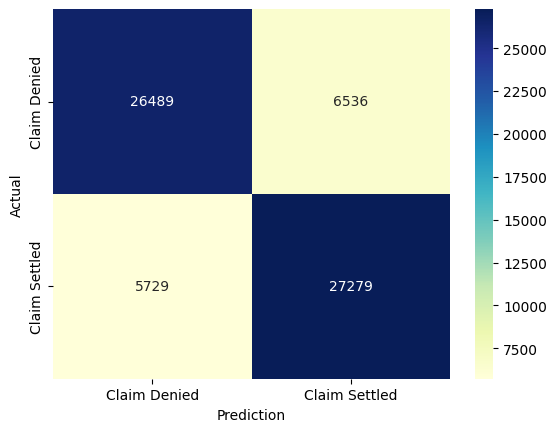

In [605]:
cm_matrix = pd.DataFrame(data=conf, columns=['Claim Denied', 'Claim Settled'], 
                                 index=['Claim Denied', 'Claim Settled'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Prediction", fontsize=10)
plt.ylabel("Actual", fontsize=10);

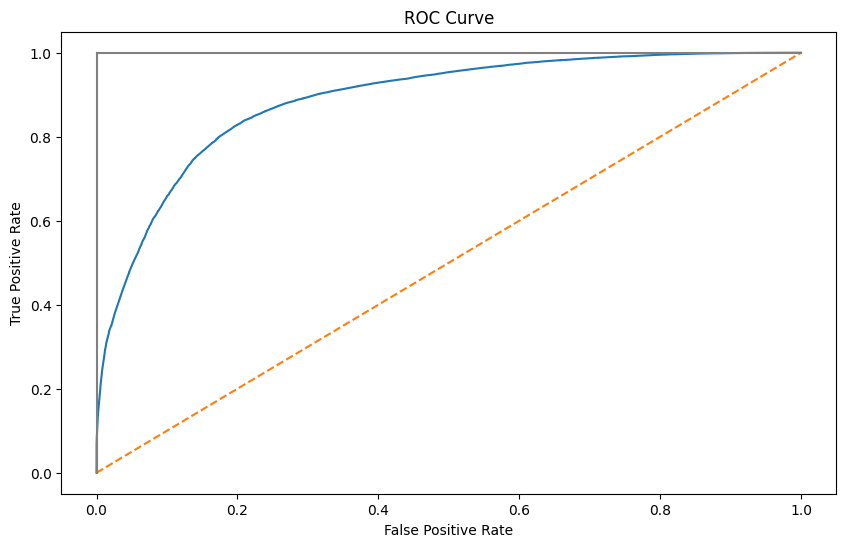

In [606]:
# plot the ROC curve
from sklearn.metrics import roc_curve

# Get the predicted probabilities
y_pred_prob = cat.predict_proba(X_test)[:,1]

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls='--')
plt.plot([0, 0], [1, 0], c='.5')
plt.plot([1, 1], c='.5')
plt.title('ROC Curve')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

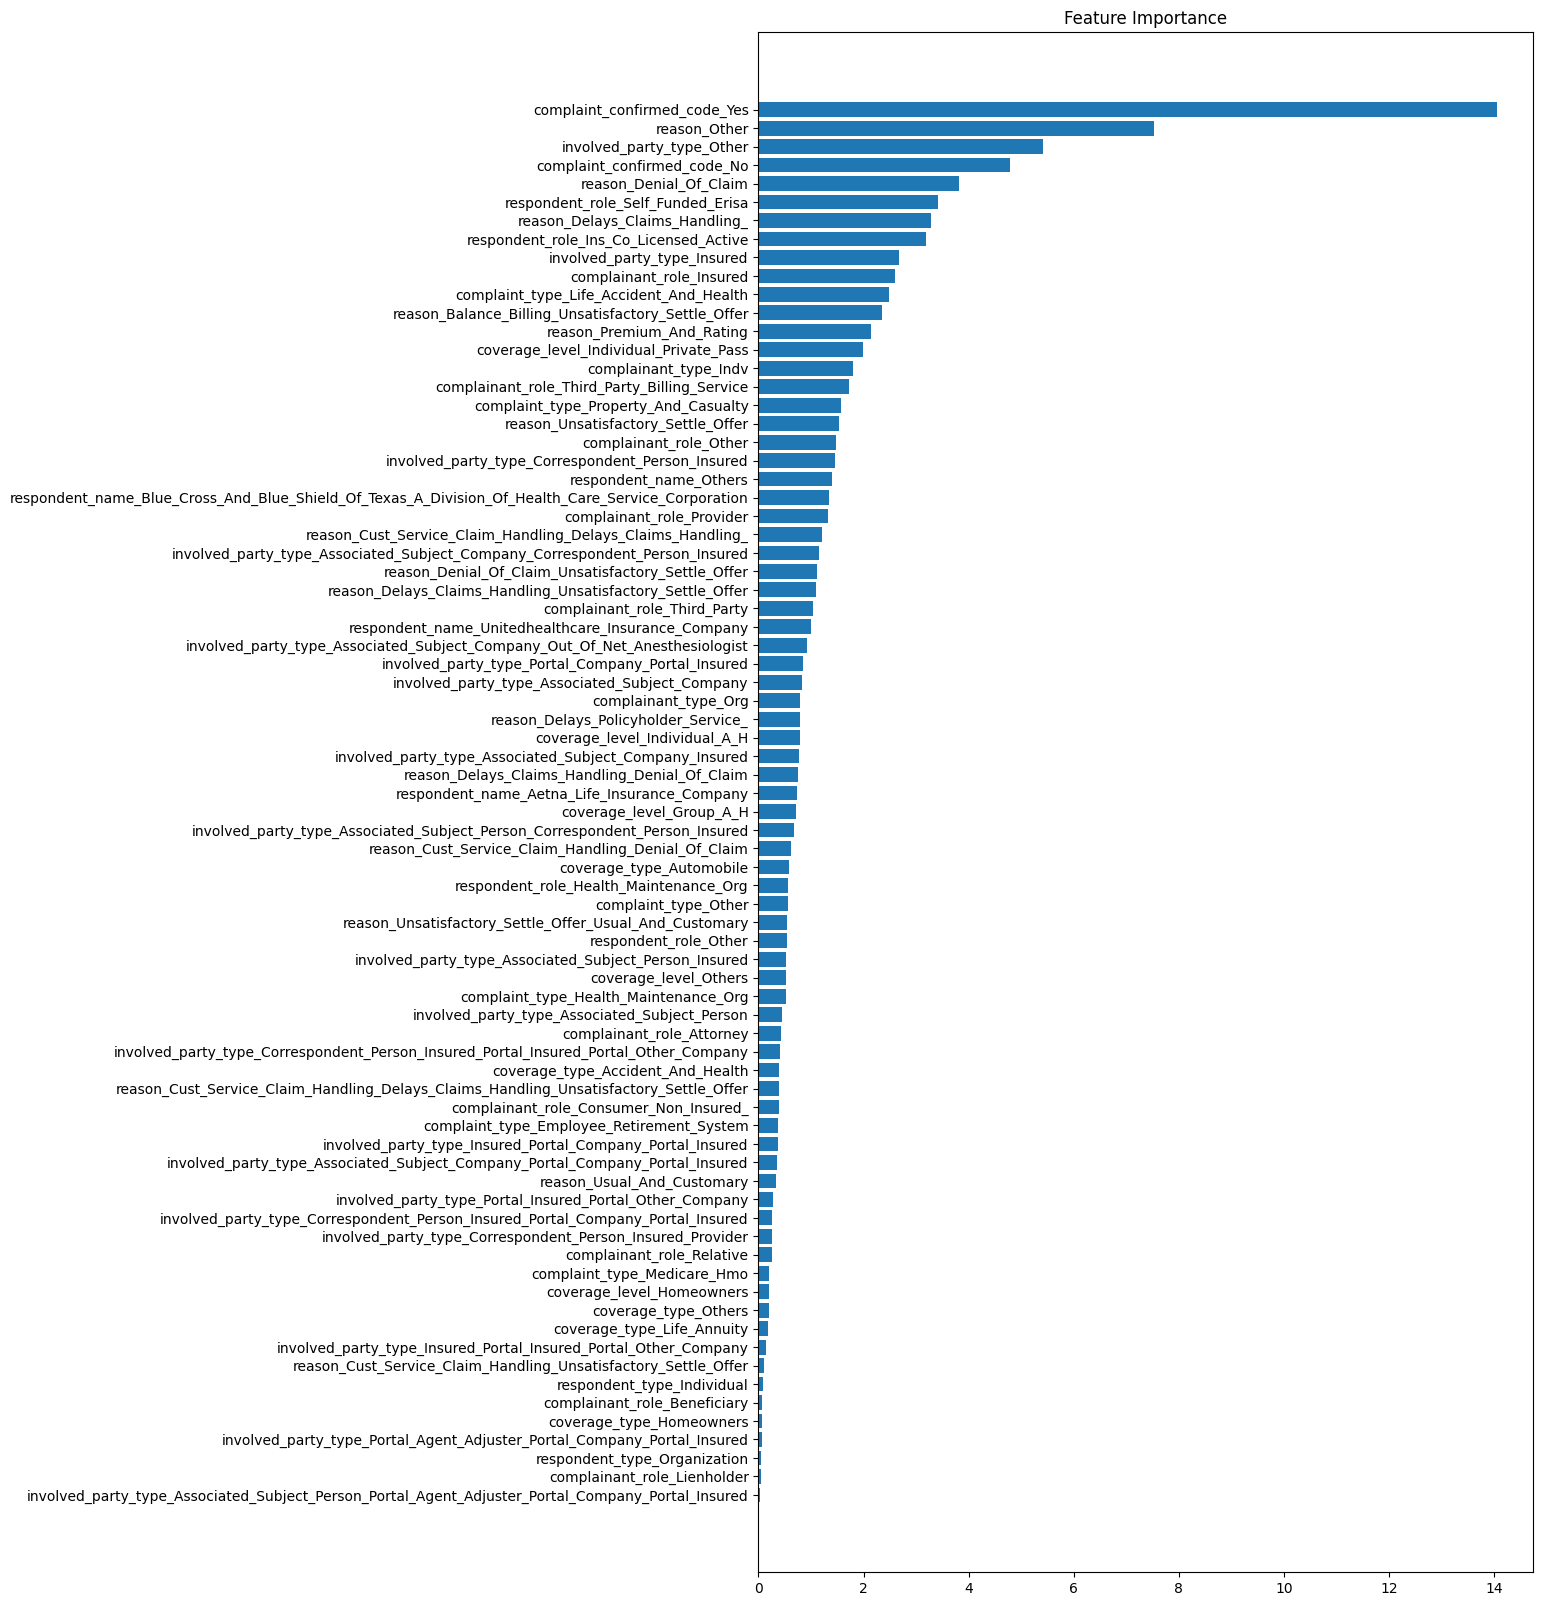

In [557]:
feature_importance = cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
# Plot the feature importances
plt.figure(figsize=(10, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

In [467]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107853 entries, 107191 to 51125
Data columns (total 76 columns):
 #   Column                                                                                             Non-Null Count   Dtype  
---  ------                                                                                             --------------   -----  
 0   respondent_name_Aetna_Life_Insurance_Company                                                       107853 non-null  float32
 1   respondent_name_Blue_Cross_And_Blue_Shield_Of_Texas_A_Division_Of_Health_Care_Service_Corporation  107853 non-null  float32
 2   respondent_name_Others                                                                             107853 non-null  float32
 3   respondent_name_Unitedhealthcare_Insurance_Company                                                 107853 non-null  float32
 4   complainant_role_Attorney                                                                          107853 non-n

In [468]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras import layers



# # Define the model
# model = tf.keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# # Evaluate the model
# test_loss, test_acc = model.evaluate(X_test, y_test)

# print(f'Test accuracy: {test_acc}')

# # Make predictions
# y_pred = model.predict(X_test)

# # Convert the predictions to binary
# y_pred = (y_pred > 0.5).astype(int)

# # Print the classification report
# print(classification_report(y_test, y_pred))

# # Print the confusion matrix
# print(confusion_matrix(y_test, y_pred))

# cm_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred), columns=['Claim Denied', 'Closed'],
#                             index=['Claim Denied', 'Closed'])

# sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
# plt.xlabel("Prediction", fontsize=10)
# plt.ylabel("Actual", fontsize=10)
# plt.show()



In [469]:
# # drop duraton column from X_train and X_test

# X_train = X_train.drop('Duration', axis=1)
# X_test = X_test.drop('Duration', axis=1)
# X_val = X_val.drop('Duration', axis=1)


Epoch 1/50
6741/6741 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7167 - auc_10: 0.7747 - loss: 0.5813 - val_accuracy: 0.7903 - val_auc_10: 0.8578 - val_loss: 0.4727 - learning_rate: 0.0010
Epoch 2/50
6741/6741 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7761 - auc_10: 0.8365 - loss: 0.4996 - val_accuracy: 0.7907 - val_auc_10: 0.8605 - val_loss: 0.4657 - learning_rate: 0.0010
Epoch 3/50
6741/6741 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7798 - auc_10: 0.8430 - loss: 0.4910 - val_accuracy: 0.7910 - val_auc_10: 0.8617 - val_loss: 0.4639 - learning_rate: 0.0010
Epoch 4/50
6741/6741 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7788 - auc_10: 0.8407 - loss: 0.4944 - val_accuracy: 0.7903 - val_auc_10: 0.8622 - val_loss: 0.4628 - learning_rate: 0.0010
Epoch 5/50
6741/6741 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7795 - auc_10: 0.8455 - loss: 0.4883 - val_accuracy: 0.7906 - val_auc_10: 0.8618 - val_loss: 0.4642 - learning_rate: 0.0010
Epoch 6/50
6741/6741 ━━━━━━━━━━━━━━

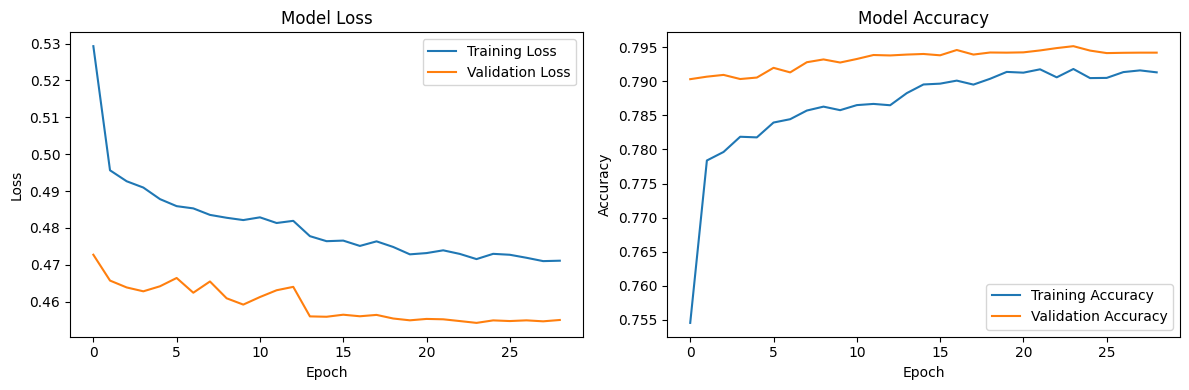

2064/2064 ━━━━━━━━━━━━━━━━━━━━ 2s 833us/step - accuracy: 0.7986 - auc_10: 0.8711 - loss: 0.4483
Test accuracy: 0.7984
Test AUC: 0.8709
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 2s 712us/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80     33025
         1.0       0.79      0.81      0.80     33008

    accuracy                           0.80     66033
   macro avg       0.80      0.80      0.80     66033
weighted avg       0.80      0.80      0.80     66033



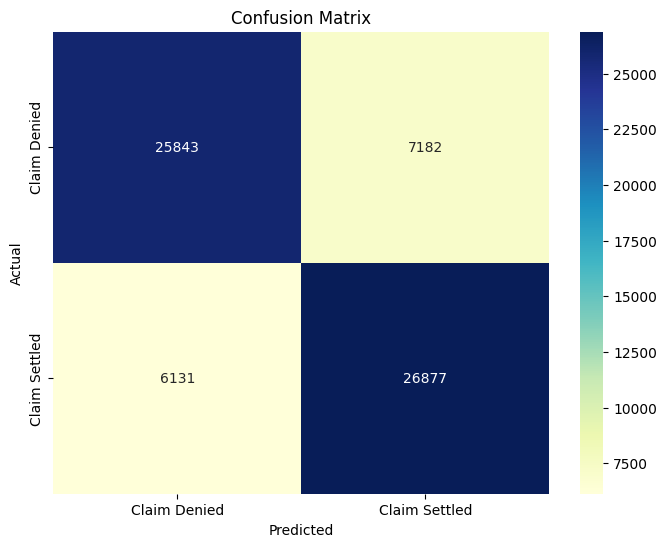

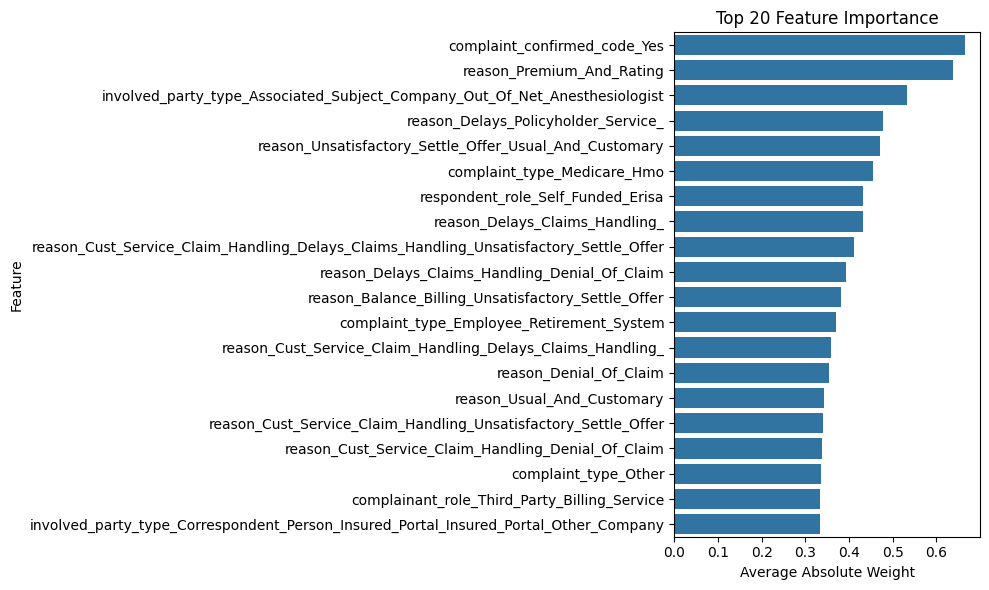

In [494]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# Assuming you have your data in a DataFrame called 'df'
# Replace this with your actual data loading code
"""
df = pd.read_csv('your_data.csv')
"""

# Separate features and target
"""
X = df.drop('target_column', axis=1)
y = df['target_column']
"""

# Convert categorical variables to dummy variables
"""
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_columns)
"""

# # Split the data into training, validation, and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

# Define the model
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Define callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=3
    )
]

# Train the model
history = model.fit(
    X_train, 
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test AUC: {test_auc:.4f}')

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create and plot confusion matrix
plt.figure(figsize=(8, 6))


cm_matrix = pd.DataFrame(
    data=confusion_matrix(y_test, y_pred),
    columns=['Claim Denied', 'Claim Settled'], 
                                 index=['Claim Denied', 'Claim Settled'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.xlabel("Predicted", fontsize=10)
plt.ylabel("Actual", fontsize=10)
plt.show()

# Feature importance analysis (based on weight magnitudes)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importance')
plt.xlabel('Average Absolute Weight')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

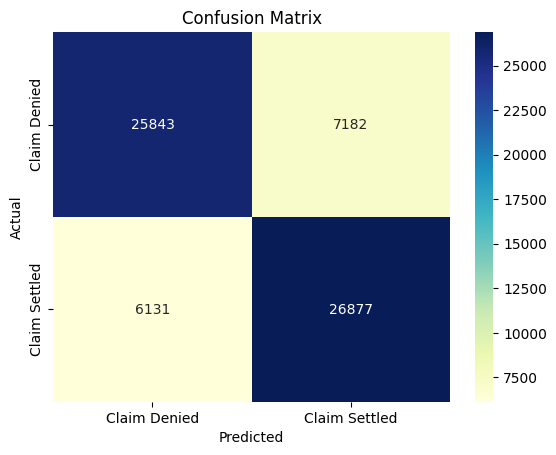

In [495]:
cm_matrix = pd.DataFrame(
    data=confusion_matrix(y_test, y_pred),
    columns=['Claim Denied', 'Claim Settled'], 
                                 index=['Claim Denied', 'Claim Settled'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.xlabel("Predicted", fontsize=10)
plt.ylabel("Actual", fontsize=10)
plt.show()